# 1. Import Library

In [ ]:
! pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=b81856aa11d50561bb6907962914946f93b62d6e906aa943be3fff26980359d3
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
import re
import pandas as pd
import numpy as np
import random
from sentence_transformers import SentenceTransformer
from sklearn.cluster import MiniBatchKMeans


import seaborn as sns
import matplotlib.pyplot as plt

# import nltk
# from nltk.tokenize import word_tokenize


# 2. Define Function

In [ ]:
# 시각화로 확인하는 함수
def visualize(df, tsne_result, label_num):
    df['kmeans_x'] = tsne_result[:, 0]
    df['kmeans_y'] = tsne_result[:, 1]

    # 그림 설정
    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns

    # 첫 번째 그래프 (scatter plot)
    for i in range(0, 6):
        _df = df[df[label_num] == i]
        axes[0].scatter(x=_df.kmeans_x, y=_df.kmeans_y, s=1)
    axes[0].set_title('Scatter Plot of KMeans')
    axes[0].set_xlabel('KMeans X')
    axes[0].set_ylabel('KMeans Y')

    # 두 번째 그래프 (histogram)
    sns.histplot(df['distance_to_center'], kde=True, ax=axes[1])
    axes[1].set_title('Distribution of Distance to Center')
    axes[1].set_xlabel('Distance to Center')
    axes[1].set_ylabel('Count')

    plt.tight_layout() # 서브플롯 간의 간격 조정
    plt.show()

# mapping 하기 위해 군집화 결과를 text로 확인하는 함수
def print_sample_tsne(df, label_num):
    for cluster in range(0,6):
        print('********** cluster {} **********'.format(cluster))
        _sample = df[df[label_num] == cluster]['text'].head(10)
        idxs = list(_sample.index)
    for idx in idxs:
        print(df['text'][idx])
    print("\n")


def filtered_df_label_to_df(filtered_df, main_df, label_num, distance_num, define):
    # filtered_df_2의 카테고리 숫자 -> 문자열
    main_df.loc[filtered_df.index, 'label'] = filtered_df[label_num]

    # 원래 df에 'label_2'열 추가
    condition_indices3 = filtered_df['label_2'].index
    main_df.loc[condition_indices3, label_num] = filtered_df[label_num]

    # 원래 df에 'label_2'가 결정되면 'define' 열에 '2'입력
    condition_indices = filtered_df[filtered_df['distance_to_center'] < distance_num].index
    main_df.loc[condition_indices, 'define'] = define

# 다시 군집화해야하는 데이터 모음
remaining_df_7 = df[~df['define'].isin([1, 2, 3, 4, 5, 6])]

def clustering(remaining_df, main_df, label_num):
    # 다시 군집화 해야하는 데이터의 비율
    print("다시 군집화 해야하는 데이터의 비율 : ",len(remaining_df) / len(main_df))

    # 텍스트 feature 추출
    sentence_embeddings = model.encode(remaining_df['processed_text'].tolist())
    # 추출한 feature를 데이터프레임에 저장
    df_embeddings = pd.DataFrame(sentence_embeddings)
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 25, n_iter = 400) # ver15 전처리함수 변경
    # tsne 객체의 fit_transform 메소드를 사용 -> df_embeddings 데이터프레임에 있는 고차원 데이터를 2차원으로 변환
    tsne_result = tsne.fit_transform(df_embeddings)
    # 군집화
    minibatch_kmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', batch_size=200, random_state=SEED)
    minibatch_kmeans_labels = minibatch_kmeans.fit_predict(tsne_result)
    remaining_df.loc[:, label_num] = minibatch_kmeans_labels
    # 각 데이터 포인트에 대해 가장 가까운 클러스터 중심까지의 거리를 계산합니다.
    distances = np.min(minibatch_kmeans.transform(tsne_result), axis=1)
    # distances 변수에는 각 데이터 포인트가 할당된 클러스터 중심까지의 거리가 저장되어 있습니다.
    remaining_df.loc[:, 'distance_to_center'] = distances

## Random Seed

In [ ]:
SEED = 7

np.random.seed(SEED)
random.seed(SEED)

## Load Data

In [ ]:
df = pd.read_csv('news.csv')
df.head()

,id,title,contents
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Lui...
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often a..."
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks A...,Yasmine Hamdan performs 'Hal' which she also s...
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of ...
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qu...


In [ ]:
# 제목 + 내용
df['text'] = df['title'] + ' : ' + df['contents']
df.head()

,id,title,contents,text
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","Bruce Lee statue for divided city : In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee."
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors,Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors : Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,Macromedia contributes to eBay Stores : Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,Qualcomm plans to phone it in on cellular repairs : Over-the-air fixes for cell phones comes to Qualcomm's CDMA.


## Pre-processing

In [ ]:
# html 태그를 제거하는 전처리 함수
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [ ]:
def preprocess_text(text):
    # URL 제거
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 해시태그 제거
    text = re.sub(r'#\w+', '', text)

    # 멘션 제거
    text = re.sub(r'@\w+', '', text)

    # 이모지 제거
    text = text.encode('ascii', 'ignore').decode('ascii')

    # 공백 및 특수문자 제거
    text = re.sub(r'\s+', ' ', text).strip()

    # 숫자 제거
    text = re.sub(r'\d+', '', text)

    return text.lower()

In [ ]:
def preprocess_text(text):
    # URL 제거
    text = re.sub(r'//www.huffingtonpost.com/entry/', '', text)
    text = re.sub(r'//www.climatecentral.org/news/', '', text)
    text = re.sub(r'//www.washingtonpost.com/', '', text)
    text = re.sub(r'//www.torrentfreak.com/', '', text)
    text = re.sub(r'//www.businessweek.com/articles/', '', text)
    text = re.sub(r'//allthingsd.com/', '', text)
    text = re.sub(r'//www.cbsnews.com/news/', '', text)
    text = re.sub(r'//www.huffingtonpost.com/entry/', '', text)
    text = re.sub(r'//www.buzzfeed.com/', '', text)
    text = re.sub(r'//insidemovies.ew.com/', '', text)
    text = re.sub(r'//www.huffingtonpost.com/entry/', '', text)
    text = re.sub(r'//www.ew.com/', '', text)
    text = re.sub(r'//nymag.com/daily/', '', text)
    text = re.sub(r'//nymag.com/thecut/', '', text)
    text = re.sub(r'//insidemovies.ew.com/', '', text)
    text = re.sub(r'//thinkprogress.org/', '', text)
    text = re.sub(r'//hoh.rollcall.com/', '', text)
    text = re.sub(r'//www.bloomberg.com/', '', text)
    text = re.sub(r'//www.huffingtonpost.com/entry/', '', text)
    text = re.sub(r'//www.fastcompany.com/', '', text)
    text = re.sub(r'//www.gossipcop.com/', '', text)
    text = re.sub(r'//www.bloomberg.com/', '', text)
    text = re.sub(r'//www.engadget.com/', '', text)
    text = re.sub(r'//247wallst.com/', '', text)
    text = re.sub(r'//247wallst.com/special-report/', '', text)
    text = re.sub(r'//gizmodo.com/', '', text)
    text = re.sub(r'//graphics.latimes.com/', '', text)
    text = re.sub(r'//fivethirtyeight.com/features/', '', text)
    text = re.sub(r'//apps.bostonglobe.com/', '', text)
    text = re.sub(r'//pubx.co/.*', '', text)

    text = re.sub(r'html', '', text)
    text = re.sub(r'short_description', '', text)
    text = re.sub(r'\\', ' ', text)

    text = re.sub(r'#\w+', '', text)

    text = re.sub(r'@\w+', '', text)

    text = text.encode('ascii', 'ignore').decode('ascii')

    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'\d+', '', text)

    return text.lower()


In [ ]:
# def remove_single_char_func(text, threshold=1):
#     words = word_tokenize(text)
#     text = ' '.join([word for word in words if len(word) > threshold])
#     return text

def remove_punctuation_func(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

def remove_extra_whitespaces_func(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

In [ ]:
df['processed_text'] = df['text'].apply(remove_html)
df['processed_text'] = df['processed_text'].apply(preprocess_text)
# df['processed_text'] = df['processed_text'].apply(remove_punctuation_func)
df['processed_text'] = df['processed_text'].apply(remove_extra_whitespaces_func)

In [ ]:
df.head()

,id,title,contents,text,processed_text
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,spanish coach facing action in race row : madrid (afp) - spanish national team coach luis aragones faces a formal investigation after spain ;s football federation decided to open disciplinary proceedings over racist comments about thierry henry of france and arsenal.
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","Bruce Lee statue for divided city : In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","bruce lee statue for divided city : in bosnia, where one man ;s hero is often another man ;s villain, some citizens have decided to honour one whom serbs, croats and muslims can all look up to - the kung fu great bruce lee."
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors,Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors : Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,only lovers left alive's tilda swinton talks about almost quitting acting and yasmine hamdan performs 'hal' live in nyc (huffpo exclusive videos) authors : yasmine hamdan performs 'hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,Macromedia contributes to eBay Stores : Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,macromedia contributes to ebay stores : macromedia has announced a special version of its contribute website editing application designed to simplify the creation and customisation of ebay stores.
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,Qualcomm plans to phone it in on cellular repairs : Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,qualcomm plans to phone it in on cellular repairs : over-the-air fixes for cell phones comes to qualcomm's cdma.


## Feature Extraction

In [ ]:
# Sentence BERT 모델 로드
model = SentenceTransformer('all-distilroberta-v1')

# 텍스트 feature 추출
sentence_embeddings = model.encode(df['processed_text'].tolist())

# 추출한 feature를 데이터프레임에 저장
df_embeddings = pd.DataFrame(sentence_embeddings)

# T-sne 차원축소
---

100%|██████████| 4/4 [22:32<00:00, 338.05s/it]


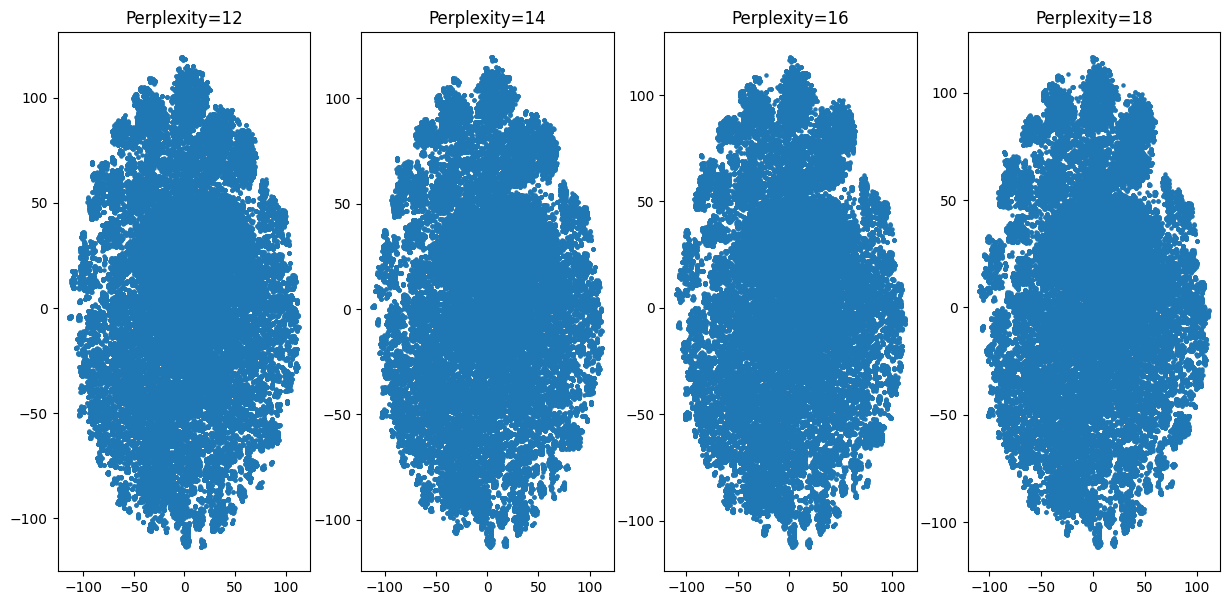

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# T-sne 의 'perplexity' 값
perplexities = [12,14,16,18]

fig, axs = plt.subplots(1, len(perplexities), figsize=(15, 7))

for i, perplexity in enumerate(tqdm(perplexities)):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=SEED)
    X_tsne = tsne.fit_transform(df_embeddings)
    axs[i].scatter(X_tsne[:, 0], X_tsne[:, 1], s=5)
    axs[i].set_title(f'Perplexity={perplexity}')

plt.show()


  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-15-9c5d335edd0b>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[i, j].scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis', s=5)

 25%|██▌       | 1/4 [02:28<07:25, 148.53s/it]<ipython-input-15-9c5d335edd0b>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[i, j].scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis', s=5)

 50%|█████     | 2/4 [05:37<05:44, 172.41s/it]<ipython-input-15-9c5d335edd0b>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[i, j].scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis', s=5)

 75%|███████▌  | 3/4 [09:29<03:19, 199.33s/it]<ipython-input-15-9c5d335edd0b>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[i, j].scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis', s=5)

 

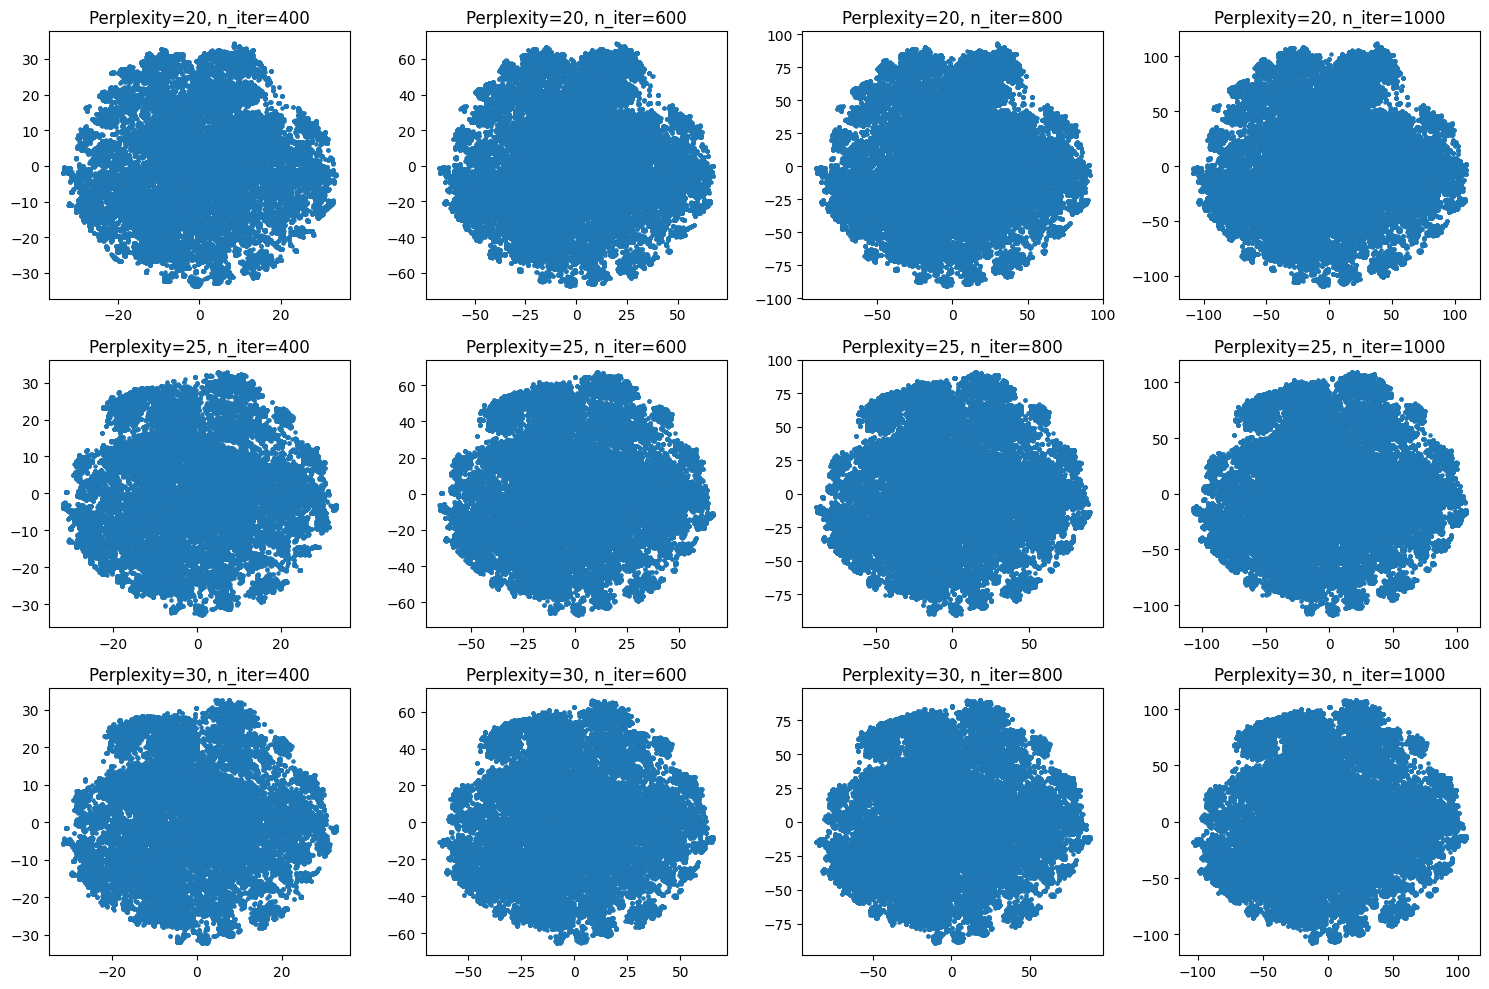

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from tqdm import tqdm

# 테스트할 perplexity와 n_iter 값 정의
perplexities = [20, 25, 30]
n_iters = [400, 600, 800, 1000]

# 결과를 저장할 figure 생성
fig, axs = plt.subplots(len(perplexities), len(n_iters), figsize=(15, 10))

# 각 하이퍼파라미터 조합에 대해 t-SNE 실행 및 시각화
for i, perplexity in enumerate(tqdm(perplexities)):
    for j, n_iter in enumerate(tqdm(n_iters)):
        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=SEED)
        tsne_result = tsne.fit_transform(df_embeddings)

        axs[i, j].scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis', s=5)
        axs[i, j].set_title(f'Perplexity={perplexity}, n_iter={n_iter}')

plt.tight_layout()
plt.show()

In [ ]:
%%time
from sklearn.manifold import TSNE

# 여기서 n_components=2는 2차원 공간으로 데이터를 축소하겠다는 것을 의미하며
# verbose=1는 진행 상황을 콘솔에 출력하겠다는 것을 의미합니다.
# perplexity=25는 모델의 복잡도를 결정하며, 일반적으로 5-50 사이의 값이 좋다고 알려져 있습니다.
# n_iter=250는 최적화에 사용할 반복 횟수입니다.
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 25, n_iter = 400) # ver15 전처리함수 변경
# tsne 객체의 fit_transform 메소드를 사용 -> df_embeddings 데이터프레임에 있는 고차원 데이터를 2차원으로 변환
tsne_result = tsne.fit_transform(df_embeddings)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.016s...
[t-SNE] Computed neighbors for 60000 samples in 47.146s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

# 2. MiniBatch K-menas ++

In [ ]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', batch_size=200, random_state=SEED)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(tsne_result)
df['label_1'] = minibatch_kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
import numpy as np

# 각 데이터 포인트에 대해 가장 가까운 클러스터 중심까지의 거리를 계산합니다.
distances = np.min(minibatch_kmeans.transform(tsne_result), axis=1)

# distances 변수에는 각 데이터 포인트가 할당된 클러스터 중심까지의 거리가 저장되어 있습니다.
df['distance_to_center'] = distances

In [ ]:
df['distance_to_center'].describe()

count    60000.000000
mean         8.696646
std          3.538137
min          0.025415
25%          6.117138
50%          8.887499
75%         11.111388
max         19.110004
Name: distance_to_center, dtype: float64

<Axes: ylabel='Count'>

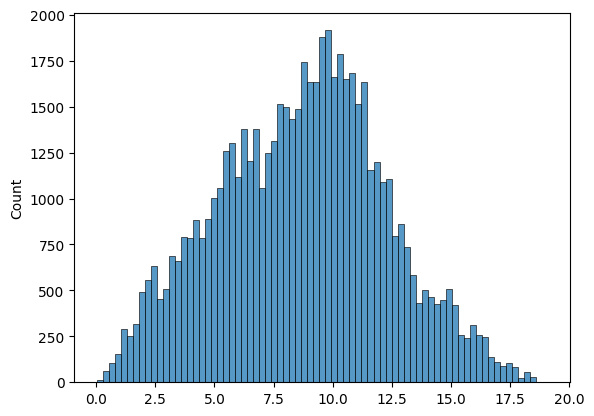

In [ ]:
sns.histplot(distances)

In [ ]:
df.head()

,id,title,contents,text,processed_text,label_1,distance_to_center
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,spanish coach facing action in race row : madrid (afp) - spanish national team coach luis aragones faces a formal investigation after spain ;s football federation decided to open disciplinary proceedings over racist comments about thierry henry of france and arsenal.,4,4.635535
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","Bruce Lee statue for divided city : In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","bruce lee statue for divided city : in bosnia, where one man ;s hero is often another man ;s villain, some citizens have decided to honour one whom serbs, croats and muslims can all look up to - the kung fu great bruce lee.",2,6.165329
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors,Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors : Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,only lovers left alive's tilda swinton talks about almost quitting acting and yasmine hamdan performs 'hal' live in nyc (huffpo exclusive videos) authors : yasmine hamdan performs 'hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,1,6.614978
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,Macromedia contributes to eBay Stores : Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,macromedia contributes to ebay stores : macromedia has announced a special version of its contribute website editing application designed to simplify the creation and customisation of ebay stores.,0,7.514455
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,Qualcomm plans to phone it in on cellular repairs : Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,qualcomm plans to phone it in on cellular repairs : over-the-air fixes for cell phones comes to qualcomm's cdma.,0,2.168601


## 1-1. 1차 군집화 결과 시각적으로 확인하기

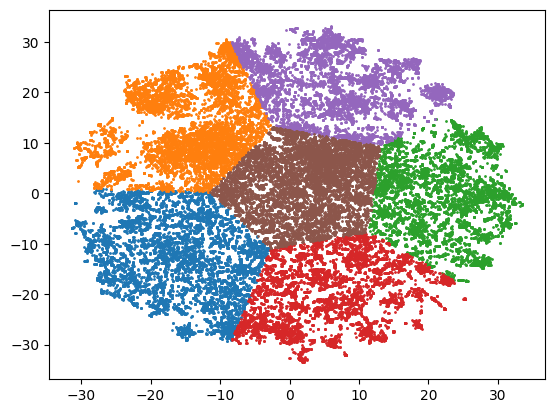

In [ ]:
import matplotlib.pyplot as plt

# kmeans = KMeans(n_clusters=6, random_state=SEED)

# df['kmeans_cluster_tsne'] = kmeans.fit_predict(tsne_result)
# df['kmeans_cluster'] = kmeans.fit_predict(df_embeddings)

df['kmeans_x'] = tsne_result[:, 0]
df['kmeans_y'] = tsne_result[:, 1]

for i in range(0, 6):
  _df = df[df['label_1'] == i]
  plt.scatter(x=_df.kmeans_x, y=_df.kmeans_y, s=1)

## 1-2. 1차 군집화 결과 Mapping

## 1-3. 1차 군집화 거리 결정하기

In [ ]:
df.loc[df['distance_to_center'] < 5, 'define'] = 1
df.loc[df['distance_to_center'] >= 5, 'define'] = None

In [ ]:
# Label이 완성
filtered_df_1 = df[df['define'] == 1]

In [ ]:
len(filtered_df_1) / len(df)

0.1649

In [ ]:
filtered_df_1.head(1)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,spanish coach facing action in race row : madrid (afp) - spanish national team coach luis aragones faces a formal investigation after spain ;s football federation decided to open disciplinary proceedings over racist comments about thierry henry of france and arsenal.,4,4.635535,7.48377,26.020975,1.0


In [ ]:
pd.set_option('display.max_colwidth', None)
def print_sample_tsne(df):
  for cluster in range(0,6):
    print('********** cluster {} **********'.format(cluster))
    _sample = df[df['label_1'] == cluster]['text'].head(8)
    idxs = list(_sample.index)
    for idx in idxs:
      print(df['text'][idx])
    print("\n")
print_sample_tsne(filtered_df_1)

********** cluster 0 **********
Qualcomm plans to phone it in on cellular repairs : Over-the-air fixes for cell phones comes to Qualcomm's CDMA.
Microsoft, Cisco: Seeing Eye-to-Eye on Network Security : Tech giants Microsoft and Cisco have agreed to develop and promote interoperability between their respective network access technologies.
Two Words from Bill Gates: Computer Science : It wasn #39;t  quot;Plastics quot; as Dustin Hoffman was advised in the movie The Graduate, but computers that Bill Gates told a college audience would be the ticket to a good career in the near future.
Siemens wins major BBC contract : A subsidiary of the German engineering giant Siemens has landed a 2.7bn euros outsourcing contract with the British Broadcasting Corporation (BBC).
Sprint, Nextel exploring merger; 40 million subscribers involved : Nextel Communications and Sprint are negotiating a possible merger, according to a source familiar with the discussions. It was not clear how far the talks had p

## filtered_df_1 mapping


0 : 'tech'
1 :
2 : 'politics'


In [ ]:
mapping1 = {
    0 : 'tech',
    1 : 'politics',
    2 : 'sports',
    3 : 'world',
    4 : 'business',
    5 : 'entertainment'
}

filtered_df_1['label_1'] = filtered_df_1['label_1'].apply(lambda x: mapping1[x])

<ipython-input-330-f1caa1757a85>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_1['label_1'] = filtered_df_1['label_1'].apply(lambda x: mapping1[x])


In [ ]:
filtered_df_1.head(1)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,spanish coach facing action in race row : madrid (afp) - spanish national team coach luis aragones faces a formal investigation after spain ;s football federation decided to open disciplinary proceedings over racist comments about thierry henry of france and arsenal.,business,4.635535,7.48377,26.020975,1.0


In [ ]:
# 이후에 매핑 작업 진행:

# filtered_df_2의 카테고리 숫자 -> 문자열
df.loc[filtered_df_1.index, 'label'] = filtered_df_1['label_1']

# 원래 df에 'label_1'열 추가
condition_indices3 = filtered_df_1['label_1'].index
df.loc[condition_indices3, 'label_1'] = filtered_df_1['label_1']

# 원래 df에 'label_1'가 결정되면 'define' 열에 '1'입력
condition_indices = filtered_df_1[filtered_df_1['distance_to_center'] < 5].index
df.loc[condition_indices, 'define'] = 1

In [ ]:
df.head(1)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,spanish coach facing action in race row : madrid (afp) - spanish national team coach luis aragones faces a formal investigation after spain ;s football federation decided to open disciplinary proceedings over racist comments about thierry henry of france and arsenal.,business,4.635535,7.48377,26.020975,1.0,business


# 2차 군집화 시행

In [ ]:
remaining_df_1 = df[df['define'] != 1]


In [ ]:
# 텍스트 feature 추출
sentence_embeddings = model.encode(remaining_df_1['processed_text'].tolist())

# 추출한 feature를 데이터프레임에 저장
df_embeddings = pd.DataFrame(sentence_embeddings)

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 25, n_iter = 400) # ver15 전처리함수 변경
# tsne 객체의 fit_transform 메소드를 사용 -> df_embeddings 데이터프레임에 있는 고차원 데이터를 2차원으로 변환
tsne_result = tsne.fit_transform(df_embeddings)

from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', batch_size=200, random_state=SEED)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(tsne_result)
remaining_df_1.loc[:, 'label_2'] = minibatch_kmeans_labels

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 50106 samples in 0.013s...
[t-SNE] Computed neighbors for 50106 samples in 33.816s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50106
[t-SNE] Computed conditional probabilities for sample 2000 / 50106
[t-SNE] Computed conditional probabilities for sample 3000 / 50106
[t-SNE] Computed conditional probabilities for sample 4000 / 50106
[t-SNE] Computed conditional probabilities for sample 5000 / 50106
[t-SNE] Computed conditional probabilities for sample 6000 / 50106
[t-SNE] Computed conditional probabilities for sample 7000 / 50106
[t-SNE] Computed conditional probabilities for sample 8000 / 50106
[t-SNE] Computed conditional probabilities for sample 9000 / 50106
[t-SNE] Computed conditional probabilities for sample 10000 / 50106
[t-SNE] Computed conditional probabilities for sample 11000 / 50106
[t-SNE] Computed conditional probabilities for sample 12000 / 50106
[t-SNE] Computed conditional probabilities for sa

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-335-c5927afd31bc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_1.loc[:, 'label_2'] = minibatch_kmeans_labels


In [ ]:


# 각 데이터 포인트에 대해 가장 가까운 클러스터 중심까지의 거리를 계산합니다.
distances = np.min(minibatch_kmeans.transform(tsne_result), axis=1)

# distances 변수에는 각 데이터 포인트가 할당된 클러스터 중심까지의 거리가 저장되어 있습니다.
remaining_df_1.loc[:, 'distance_to_center'] = distances


<ipython-input-336-3acf2527e2a3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_1.loc[:, 'distance_to_center'] = distances


In [ ]:
remaining_df_1.head(1)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","Bruce Lee statue for divided city : In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","bruce lee statue for divided city : in bosnia, where one man ;s hero is often another man ;s villain, some citizens have decided to honour one whom serbs, croats and muslims can all look up to - the kung fu great bruce lee.",2,11.163743,17.832108,-5.094157,NaN,NaN,3


<ipython-input-338-5fff852515d8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_1['kmeans_x'] = tsne_result[:, 0]
<ipython-input-338-5fff852515d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_1['kmeans_y'] = tsne_result[:, 1]


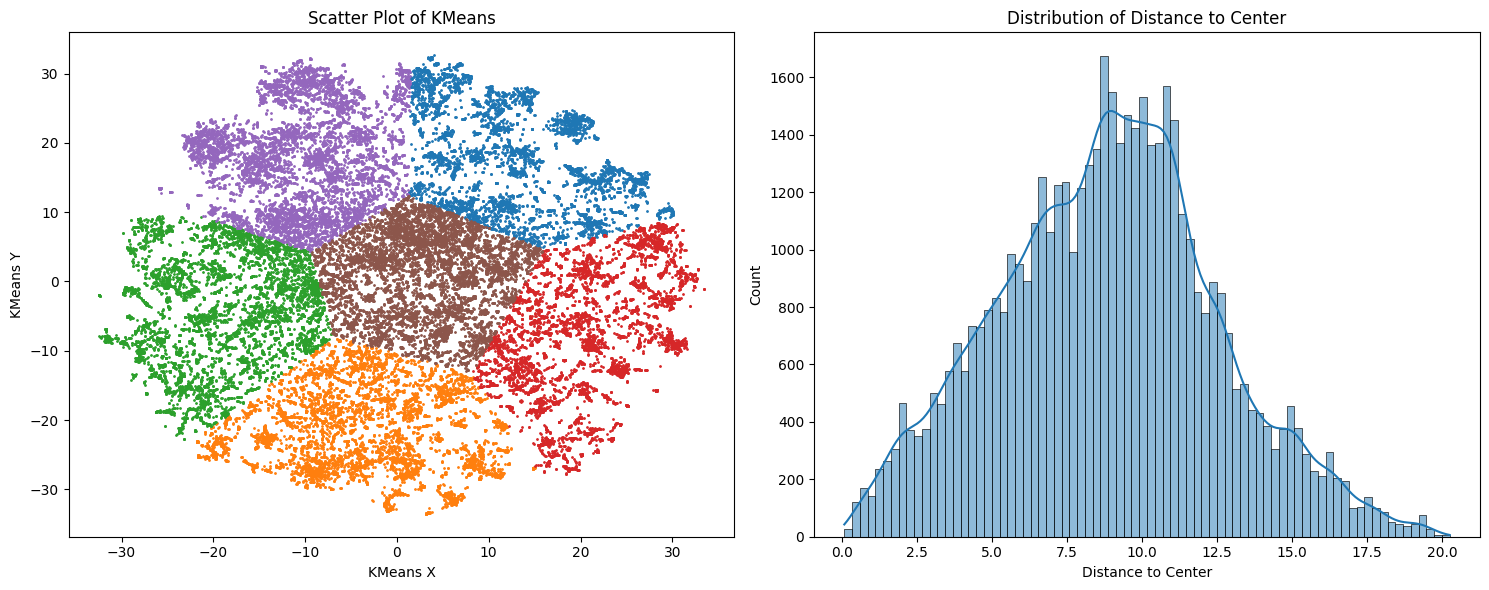

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 및 필요한 컬럼 설정
remaining_df_1['kmeans_x'] = tsne_result[:, 0]
remaining_df_1['kmeans_y'] = tsne_result[:, 1]

# 그림 설정
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns

# 첫 번째 그래프 (scatter plot)
for i in range(0, 6):
    _df = remaining_df_1[remaining_df_1['label_2'] == i]
    axes[0].scatter(x=_df.kmeans_x, y=_df.kmeans_y, s=1)
axes[0].set_title('Scatter Plot of KMeans')
axes[0].set_xlabel('KMeans X')
axes[0].set_ylabel('KMeans Y')

# 두 번째 그래프 (histogram)
sns.histplot(remaining_df_1['distance_to_center'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Distance to Center')
axes[1].set_xlabel('Distance to Center')
axes[1].set_ylabel('Count')

plt.tight_layout() # 서브플롯 간의 간격 조정
plt.show()


In [ ]:
remaining_df_1['distance_to_center'].describe()

count    50106.000000
mean         8.851006
std          3.656269
min          0.067237
25%          6.318882
50%          8.916959
75%         11.149857
max         20.254091
Name: distance_to_center, dtype: float64

In [ ]:
remaining_df_1.head(1)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","Bruce Lee statue for divided city : In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","bruce lee statue for divided city : in bosnia, where one man ;s hero is often another man ;s villain, some citizens have decided to honour one whom serbs, croats and muslims can all look up to - the kung fu great bruce lee.",2,11.163743,19.236244,3.160757,NaN,NaN,3


In [ ]:
df.head(10)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Lui...,Spanish coach facing action in race row : MADR...,spanish coach facing action in race row : madr...,4,4.635535,7.483770,26.020975,1.0,business
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often a...","Bruce Lee statue for divided city : In Bosnia,...","bruce lee statue for divided city : in bosnia,...",2,6.165329,17.832108,-5.094157,NaN,NaN
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks A...,Yasmine Hamdan performs 'Hal' which she also s...,Only Lovers Left Alive's Tilda Swinton Talks A...,only lovers left alive's tilda swinton talks a...,1,6.614978,-10.674074,8.462827,NaN,NaN
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of ...,Macromedia contributes to eBay Stores : Macrom...,macromedia contributes to ebay stores : macrom...,0,7.514455,-23.450583,-13.033397,NaN,NaN
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qu...,Qualcomm plans to phone it in on cellular repa...,qualcomm plans to phone it in on cellular repa...,0,2.168601,-14.295641,-14.079838,1.0,tech
5,NEWS_00005,Thomson to Back Both Blu-ray and HD-DVD,"Company, one of the core backers of Blu-ray, w...",Thomson to Back Both Blu-ray and HD-DVD : Comp...,thomson to back both blu-ray and hd-dvd : comp...,0,15.243399,-27.623426,-2.875136,NaN,NaN
6,NEWS_00006,Time to Talk Baseball,It's time to talk about the serious risks and ...,Time to Talk Baseball : It's time to talk abou...,time to talk baseball : it's time to talk abou...,1,2.159142,-15.752131,15.533504,1.0,politics
7,NEWS_00007,Bump Stock Maker Resumes Sales One Month After...,Move along nothing to see here.,Bump Stock Maker Resumes Sales One Month After...,bump stock maker resumes sales one month after...,5,1.989929,1.344951,-0.358584,1.0,entertainment
8,NEWS_00008,Obama Marks Anniversary Of 9/11 Attacks With M...,We stand as strong as ever.,Obama Marks Anniversary Of 9/11 Attacks With M...,obama marks anniversary of / attacks with mome...,2,9.148884,15.339596,5.632359,NaN,NaN
9,NEWS_00009,Republican Congressman Says Trump Should Apolo...,Best not to hold your breath on that one.,Republican Congressman Says Trump Should Apolo...,republican congressman says trump should apolo...,5,8.070861,3.778694,9.371485,NaN,NaN


In [ ]:
# 거리가 5 이하
filtered_df_2 = remaining_df_1[remaining_df_1['distance_to_center'] < 5]

In [ ]:
condition_indices = remaining_df_1[remaining_df_1['distance_to_center'] < 5].index
df.loc[df.index.isin(condition_indices), 'define'] = 2

In [ ]:
filtered_df_2.head(1)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2
10,NEWS_00010,Harry #39;s argy-bargy,PRINCE Charles has asked Scotland Yard for an in-depth report on his son Harry #39;s trip to Argentina after reports of excessive drinking and a kidnap plot.,Harry #39;s argy-bargy : PRINCE Charles has asked Scotland Yard for an in-depth report on his son Harry #39;s trip to Argentina after reports of excessive drinking and a kidnap plot.,harry ;s argy-bargy : prince charles has asked scotland yard for an in-depth report on his son harry ;s trip to argentina after reports of excessive drinking and a kidnap plot.,2,3.907396,10.79317,14.24359,NaN,NaN,0


In [ ]:
df.head(1)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,spanish coach facing action in race row : madrid (afp) - spanish national team coach luis aragones faces a formal investigation after spain ;s football federation decided to open disciplinary proceedings over racist comments about thierry henry of france and arsenal.,4,4.635535,7.48377,26.020975,1.0,business


In [ ]:
len(filtered_df_2) / len(remaining_df_1)

0.15808486009659523

In [ ]:
pd.set_option('display.max_colwidth', None)
def print_sample_tsne(df):
  for cluster in range(0,6):
    print('********** cluster {} **********'.format(cluster))
    _sample = df[df['label_2'] == cluster]['text'].head(10)
    idxs = list(_sample.index)
    for idx in idxs:
      print(df['text'][idx])
    print("\n")
print_sample_tsne(filtered_df_2)

********** cluster 0 **********
Harry #39;s argy-bargy : PRINCE Charles has asked Scotland Yard for an in-depth report on his son Harry #39;s trip to Argentina after reports of excessive drinking and a kidnap plot.
Fischer's Fiancee: Marriage Plans Genuine (AP) : AP - Former chess champion Bobby Fischer's announcement thathe is engaged to a Japanese woman could win him sympathy among Japanese officials and help him avoid deportation to the United States, his fiancee and one of his supporters said Tuesday.
Jordan: Ford decision was knife through the heart. : The Jordan team has vowed to bounce back from its latest crisis, despite likening Ford #39;s recent decision to cease all of its Formula One activities to a .
Prince Harry set for army career : Prince Harry will join the army in early 2005 after passing his Sandhurst entrance exams, says Clarence House.
Schumacher wins Japanese Grand Prix: : Sports India: Tokyo, Oct 10 : Michael Schumacher on his Ferrari breezed to a sixth victory o

In [ ]:
mapping2 = {
    0 : 'entertainment',  # 분류가 애매하다
    1 : 'business',
    2 : 'tech',
    3 : 'world',
    4 : 'sports',
    5 : 'politics'
}

filtered_df_2['label_2'] = filtered_df_2['label_2'].apply(lambda x: mapping2[x])


<ipython-input-343-d06f7401011b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_2['label_2'] = filtered_df_2['label_2'].apply(lambda x: mapping2[x])


In [ ]:
filtered_df_2.head(1)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2
10,NEWS_00010,Harry #39;s argy-bargy,PRINCE Charles has asked Scotland Yard for an in-depth report on his son Harry #39;s trip to Argentina after reports of excessive drinking and a kidnap plot.,Harry #39;s argy-bargy : PRINCE Charles has asked Scotland Yard for an in-depth report on his son Harry #39;s trip to Argentina after reports of excessive drinking and a kidnap plot.,harry ;s argy-bargy : prince charles has asked scotland yard for an in-depth report on his son harry ;s trip to argentina after reports of excessive drinking and a kidnap plot.,2,3.907396,10.79317,14.24359,NaN,NaN,entertainment


In [ ]:
# filtered_df_2의 카테고리 숫자 -> 문자열
df.loc[filtered_df_2.index, 'label'] = filtered_df_2['label_2']

# 원래 df에 'label_2'열 추가
condition_indices3 = filtered_df_2['label_2'].index
df.loc[condition_indices3, 'label_2'] = filtered_df_2['label_2']

# 원래 df에 'label_2'가 결정되면 'define' 열에 '2'입력
condition_indices = filtered_df_2[filtered_df_2['distance_to_center'] < 5].index
df.loc[condition_indices, 'define'] = 2



In [ ]:
filtered_df_2.head(1)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2
10,NEWS_00010,Harry #39;s argy-bargy,PRINCE Charles has asked Scotland Yard for an in-depth report on his son Harry #39;s trip to Argentina after reports of excessive drinking and a kidnap plot.,Harry #39;s argy-bargy : PRINCE Charles has asked Scotland Yard for an in-depth report on his son Harry #39;s trip to Argentina after reports of excessive drinking and a kidnap plot.,harry ;s argy-bargy : prince charles has asked scotland yard for an in-depth report on his son harry ;s trip to argentina after reports of excessive drinking and a kidnap plot.,2,3.907396,10.79317,14.24359,NaN,NaN,entertainment


In [ ]:
df.head(20)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2,label_3
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,spanish coach facing action in race row : madrid (afp) - spanish national team coach luis aragones faces a formal investigation after spain ;s football federation decided to open disciplinary proceedings over racist comments about thierry henry of france and arsenal.,4,4.635535,7.483770,26.020975,1.0,NaN,NaN,NaN
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","Bruce Lee statue for divided city : In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","bruce lee statue for divided city : in bosnia, where one man ;s hero is often another man ;s villain, some citizens have decided to honour one whom serbs, croats and muslims can all look up to - the kung fu great bruce lee.",2,6.165329,17.832108,-5.094157,NaN,NaN,NaN,NaN
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors,Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors : Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,only lovers left alive's tilda swinton talks about almost quitting acting and yasmine hamdan performs 'hal' live in nyc (huffpo exclusive videos) authors : yasmine hamdan performs 'hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,1,6.614978,-10.674074,8.462827,NaN,NaN,NaN,NaN
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,Macromedia contributes to eBay Stores : Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,macromedia contributes to ebay stores : macromedia has announced a special version of its contribute website editing application designed to simplify the creation and customisation of ebay stores.,0,7.514455,-23.450583,-13.033397,NaN,NaN,NaN,NaN
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,Qualcomm plans to phone it in on cellular repairs : Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,qualcomm plans to phone it in on cellular repairs : over-the-air fixes for cell phones comes to qualcomm's cdma.,0,2.168601,-14.295641,-14.079838,1.0,NaN,NaN,NaN
5,NEWS_00005,Thomson to Back Both Blu-ray and HD-DV

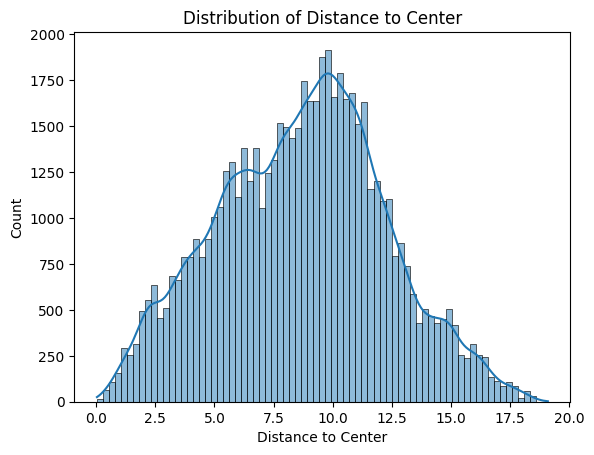

In [ ]:
import seaborn as sns

sns.histplot(df['distance_to_center'], kde=True)
plt.title('Distribution of Distance to Center')
plt.xlabel('Distance to Center')
plt.ylabel('Count')
plt.show()

In [ ]:
remaining_df_2 = df[(df['define'] != 1) & (df['define'] != 2)]

# 3차 군집화

In [ ]:
# 텍스트 feature 추출
sentence_embeddings = model.encode(remaining_df_2['processed_text'].tolist())

# 추출한 feature를 데이터프레임에 저장
df_embeddings = pd.DataFrame(sentence_embeddings)

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 25, n_iter = 400) # ver15 전처리함수 변경
# tsne 객체의 fit_transform 메소드를 사용 -> df_embeddings 데이터프레임에 있는 고차원 데이터를 2차원으로 변환
tsne_result = tsne.fit_transform(df_embeddings)

from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', batch_size=200, random_state=SEED)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(tsne_result)
remaining_df_2.loc[:, 'label_3'] = minibatch_kmeans_labels

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 42185 samples in 0.011s...
[t-SNE] Computed neighbors for 42185 samples in 24.190s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42185
[t-SNE] Computed conditional probabilities for sample 2000 / 42185
[t-SNE] Computed conditional probabilities for sample 3000 / 42185
[t-SNE] Computed conditional probabilities for sample 4000 / 42185
[t-SNE] Computed conditional probabilities for sample 5000 / 42185
[t-SNE] Computed conditional probabilities for sample 6000 / 42185
[t-SNE] Computed conditional probabilities for sample 7000 / 42185
[t-SNE] Computed conditional probabilities for sample 8000 / 42185
[t-SNE] Computed conditional probabilities for sample 9000 / 42185
[t-SNE] Computed conditional probabilities for sample 10000 / 42185
[t-SNE] Computed conditional probabilities for sample 11000 / 42185
[t-SNE] Computed conditional probabilities for sample 12000 / 42185
[t-SNE] Computed conditional probabilities for sa

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-346-7f5490f7fbe7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_2.loc[:, 'label_3'] = minibatch_kmeans_labels


In [ ]:
# 각 데이터 포인트에 대해 가장 가까운 클러스터 중심까지의 거리를 계산합니다.
distances = np.min(minibatch_kmeans.transform(tsne_result), axis=1)

# distances 변수에는 각 데이터 포인트가 할당된 클러스터 중심까지의 거리가 저장되어 있습니다.
remaining_df_2.loc[:, 'distance_to_center'] = distances

<ipython-input-347-1c09eb79581a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_2.loc[:, 'distance_to_center'] = distances


<ipython-input-348-c021e6c8d625>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_2['kmeans_x'] = tsne_result[:, 0]
<ipython-input-348-c021e6c8d625>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_2['kmeans_y'] = tsne_result[:, 1]


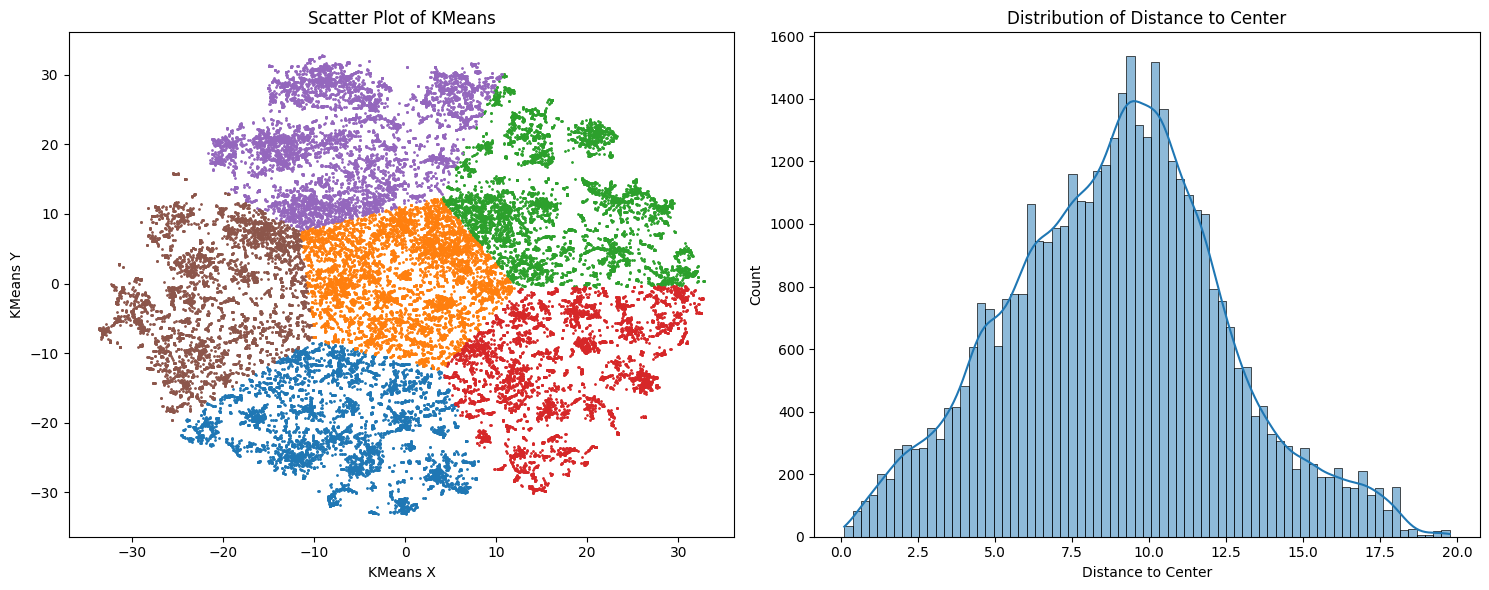

In [ ]:
# 데이터 및 필요한 컬럼 설정
remaining_df_2['kmeans_x'] = tsne_result[:, 0]
remaining_df_2['kmeans_y'] = tsne_result[:, 1]

# 그림 설정
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns

# 첫 번째 그래프 (scatter plot)
for i in range(0, 6):
    _df = remaining_df_2[remaining_df_2['label_3'] == i]
    axes[0].scatter(x=_df.kmeans_x, y=_df.kmeans_y, s=1)
axes[0].set_title('Scatter Plot of KMeans')
axes[0].set_xlabel('KMeans X')
axes[0].set_ylabel('KMeans Y')

# 두 번째 그래프 (histogram)
sns.histplot(remaining_df_2['distance_to_center'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Distance to Center')
axes[1].set_xlabel('Distance to Center')
axes[1].set_ylabel('Count')

plt.tight_layout() # 서브플롯 간의 간격 조정
plt.show()


In [ ]:
remaining_df_2['distance_to_center'].describe()

count    42185.000000
mean         8.934519
std          3.518508
min          0.118878
25%          6.470446
50%          9.070774
75%         11.188958
max         19.761597
Name: distance_to_center, dtype: float64

In [ ]:
filtered_df_3 = remaining_df_2[remaining_df_2['distance_to_center'] < 5]
condition_indices = remaining_df_2[remaining_df_2['distance_to_center'] < 5].index
df.loc[df.index.isin(condition_indices), 'define'] = 3

In [ ]:
len(filtered_df_3) / len(remaining_df_2)

0.142775868199597

In [ ]:
pd.set_option('display.max_colwidth', None)
def print_sample_tsne(df):
  for cluster in range(0,6):
    print('********** cluster {} **********'.format(cluster))
    _sample = df[df['label_3'] == cluster]['text'].head(10)
    idxs = list(_sample.index)
    for idx in idxs:
      print(df['text'][idx])
    print("\n")
print_sample_tsne(filtered_df_3)

********** cluster 0 **********
Tuesday Morning Lowers 2004 Guidance : Home accessories and gift retailer Tuesday Morning Corp. on Monday lowered its 2004 earnings guidance and forecast fourth-quarter results below Wall Street expectations on lower-than-expected seasonal sales.
Online Travel #39;s Narrowing Horizons : After some four months of waiting for both the Google (GOOG ; ranked hold; recent price: \$108) IPO and our subsequent initiation of coverage on the shares to be completed, I, like many Americans this time of year, am thinking about one thing -- travel.
UPDATE 1-S amp;P revises Poland outlook to stable from negative : Standard  amp; Poor #39;s Ratings Services on Thursday revised its credit ratings outlook on Poland to stable from negative supported by strength in export growth and an improvement in the country #39;s fiscal performance.
3Com Lowers Revenue Forecast, Shares Drop : 3Com Corp. , a smaller rival of telecommunications equipment maker Cisco Systems Inc. , on Fr

In [ ]:
mapping3 = {
    0 : 'business',
    1 : 'entertainment',
    2 : 'politics',
    3 : 'world',
    4 : 'sports',
    5 : 'tech'
}

filtered_df_3['label_3'] = filtered_df_3['label_3'].apply(lambda x: mapping3[x])

<ipython-input-353-fef81a1eab9d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_3['label_3'] = filtered_df_3['label_3'].apply(lambda x: mapping3[x])


In [ ]:
filtered_df_3.head(1)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2,label_3
5,NEWS_00005,Thomson to Back Both Blu-ray and HD-DVD,"Company, one of the core backers of Blu-ray, will also support its rival format.","Thomson to Back Both Blu-ray and HD-DVD : Company, one of the core backers of Blu-ray, will also support its rival format.","thomson to back both blu-ray and hd-dvd : company, one of the core backers of blu-ray, will also support its rival format.",0,4.582803,-25.780455,-0.708573,NaN,NaN,NaN,tech


In [ ]:
# 원래 df에 'label_3'열 추가
condition_indices1 = filtered_df_3['label_3'].index
df.loc[condition_indices1, 'label_3'] = filtered_df_3['label_3']

# filtered_df_3의 카테고리(문자열)을 df에도 적용한다.
df.loc[filtered_df_3.index, 'label'] = filtered_df_3['label_3']

# 원래 df에 'label_3'가 결정되면 'define' 열에 '3'입력
condition_indices2 = filtered_df_3[filtered_df_3['distance_to_center'] < 5].index
df.loc[condition_indices2, 'define'] = 3

In [ ]:
df.head(30)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2,label_3,label_4,label_5,label_6,label_7,label_8
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,spanish coach facing action in race row : madrid (afp) - spanish national team coach luis aragones faces a formal investigation after spain ;s football federation decided to open disciplinary proceedings over racist comments about thierry henry of france and arsenal.,business,4.635535,7.483770,26.020975,1.0,business,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","Bruce Lee statue for divided city : In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","bruce lee statue for divided city : in bosnia, where one man ;s hero is often another man ;s villain, some citizens have decided to honour one whom serbs, croats and muslims can all look up to - the kung fu great bruce lee.",2,6.165329,17.832108,-5.094157,4.0,world,NaN,NaN,world,NaN,NaN,NaN,NaN
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors,Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors : Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,only lovers left alive's tilda swinton talks about almost quitting acting and yasmine hamdan performs 'hal' live in nyc (huffpo exclusive videos) authors : yasmine hamdan performs 'hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,1,6.614978,-10.674074,8.462827,8.0,entertainment,NaN,NaN,NaN,NaN,NaN,NaN,entertainment
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,Macromedia contributes to eBay Stores : Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,macromedia contributes to ebay stores : macromedia has announced a special version of its contribute website editing application designed to simplify the creation and customisation of ebay stores.,0,7.514455,-23.450583,-13.033397,7.0,tech,NaN,NaN,NaN,NaN,NaN,tech,NaN
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,Qualcomm plans to phone it in on cellular repairs : Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,qualcomm plans to phone it in on cellular repairs : ove

# 4차 군집화

In [ ]:
remaining_df_3 = df[(df['define'] != 1) & (df['define'] != 2) & (df['define'] != 3)]
len(remaining_df_3) / len(df)

0.6027

In [ ]:
# 텍스트 feature 추출
sentence_embeddings = model.encode(remaining_df_3['processed_text'].tolist())

# 추출한 feature를 데이터프레임에 저장
df_embeddings = pd.DataFrame(sentence_embeddings)

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 25, n_iter = 400) # ver15 전처리함수 변경
# tsne 객체의 fit_transform 메소드를 사용 -> df_embeddings 데이터프레임에 있는 고차원 데이터를 2차원으로 변환
tsne_result = tsne.fit_transform(df_embeddings)

from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', batch_size=200, random_state=SEED)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(tsne_result)
remaining_df_3.loc[:, 'label_4'] = minibatch_kmeans_labels

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 36162 samples in 0.010s...
[t-SNE] Computed neighbors for 36162 samples in 16.824s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36162
[t-SNE] Computed conditional probabilities for sample 2000 / 36162
[t-SNE] Computed conditional probabilities for sample 3000 / 36162
[t-SNE] Computed conditional probabilities for sample 4000 / 36162
[t-SNE] Computed conditional probabilities for sample 5000 / 36162
[t-SNE] Computed conditional probabilities for sample 6000 / 36162
[t-SNE] Computed conditional probabilities for sample 7000 / 36162
[t-SNE] Computed conditional probabilities for sample 8000 / 36162
[t-SNE] Computed conditional probabilities for sample 9000 / 36162
[t-SNE] Computed conditional probabilities for sample 10000 / 36162
[t-SNE] Computed conditional probabilities for sample 11000 / 36162
[t-SNE] Computed conditional probabilities for sample 12000 / 36162
[t-SNE] Computed conditional probabilities for sa

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-358-83bac928b0f6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_3.loc[:, 'label_4'] = minibatch_kmeans_labels


In [ ]:
# 각 데이터 포인트에 대해 가장 가까운 클러스터 중심까지의 거리를 계산합니다.
distances = np.min(minibatch_kmeans.transform(tsne_result), axis=1)

# distances 변수에는 각 데이터 포인트가 할당된 클러스터 중심까지의 거리가 저장되어 있습니다.
remaining_df_3.loc[:, 'distance_to_center'] = distances

<ipython-input-359-e7e423e2a2af>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_3.loc[:, 'distance_to_center'] = distances


<ipython-input-360-50ca2a0cb67e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_3['kmeans_x'] = tsne_result[:, 0]
<ipython-input-360-50ca2a0cb67e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_3['kmeans_y'] = tsne_result[:, 1]


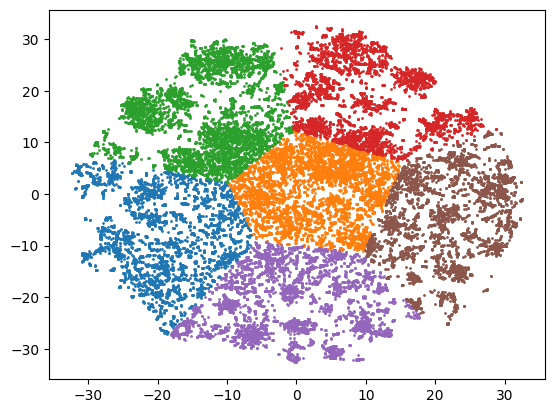

In [ ]:
import matplotlib.pyplot as plt

remaining_df_3['kmeans_x'] = tsne_result[:, 0]
remaining_df_3['kmeans_y'] = tsne_result[:, 1]

for i in range(0, 6):
  _df = remaining_df_3[remaining_df_3['label_4'] == i]
  plt.scatter(x=_df.kmeans_x, y=_df.kmeans_y, s=1)


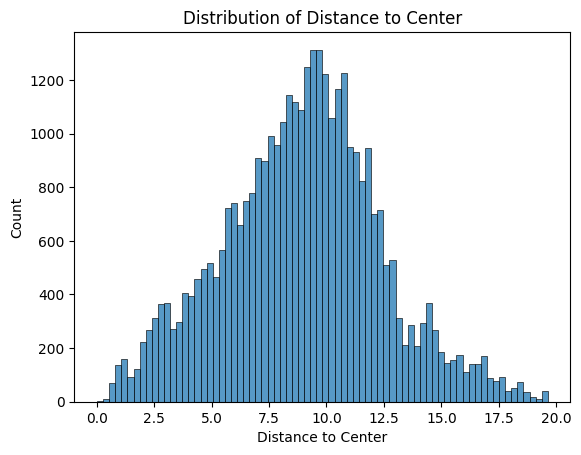

In [ ]:
import seaborn as sns

sns.histplot(remaining_df_3['distance_to_center'])
plt.title('Distribution of Distance to Center')
plt.xlabel('Distance to Center')
plt.ylabel('Count')
plt.show()

In [ ]:
remaining_df_3['distance_to_center'].describe()

count    36162.000000
mean         8.952153
std          3.441566
min          0.011153
25%          6.696611
50%          9.076119
75%         11.101823
max         19.633753
Name: distance_to_center, dtype: float64

In [ ]:
filtered_df_4 = remaining_df_3[remaining_df_3['distance_to_center'] < 5]
condition_indices = remaining_df_3[remaining_df_3['distance_to_center'] < 5].index
df.loc[df.index.isin(condition_indices), 'define'] = 4

In [ ]:
len(filtered_df_4) / len(remaining_df_3)

0.13503124827166638

In [ ]:
pd.set_option('display.max_colwidth', None)
def print_sample_tsne(df):
  for cluster in range(0,6):
    print('********** cluster {} **********'.format(cluster))
    _sample = df[df['label_4'] == cluster]['text'].head(10)
    idxs = list(_sample.index)
    for idx in idxs:
      print(df['text'][idx])
    print("\n")
print_sample_tsne(filtered_df_4)

********** cluster 0 **********
FTC Files First Lawsuit Against Spyware Concerns : The Federal Trade Commission formally announced yesterday its first assault against spyware - bits of computer code that surreptitiously install themselves on the computers of Internet users
Suit by Cities Says Microsoft Overcharged : icrosoft, which has agreed to pay \$1.8 billion to settle consumer antitrust suits, has been sued by California munciplaties, including Los Angeles and San Francisco, over claims that the company overcharged them for its Windows software.
What Apple's U2 Stunt Really Says About the Future of Music authors : The devaluation of music has also the devalued the listener. Maybe the problem with music isn't technology. Maybe it's us. Could it be that the music industry is sinking and fewer people are buying music -- not only because people don't want to pay for it but because listening to music is now officially a lost art?
Ballmer Visits New Campus in India : Microsoft is also p

In [ ]:
mapping4 = {
    0 : 'tech',
    1 : 'world',
    2 : 'sports',
    3 : 'entertainment',
    4 : 'politics',
    5 : 'business'

}

filtered_df_4['label_4'] = filtered_df_4['label_4'].apply(lambda x: mapping4[x])

<ipython-input-366-f7751b126b2a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_4['label_4'] = filtered_df_4['label_4'].apply(lambda x: mapping4[x])


In [ ]:
# filtered_df_2의 카테고리 숫자 -> 문자열
df.loc[filtered_df_4.index, 'label'] = filtered_df_4['label_4']

# 원래 df에 'label_4'열 추가
condition_indices3 = filtered_df_4['label_4'].index
df.loc[condition_indices3, 'label_4'] = filtered_df_4['label_4']

# 원래 df에 'label_4'가 결정되면 'define' 열에 '4'입력
condition_indices = filtered_df_4[filtered_df_4['distance_to_center'] < 5].index
df.loc[condition_indices, 'define'] = 4

In [ ]:
df.head(10)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2,label_3,label_4
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,spanish coach facing action in race row : madrid (afp) - spanish national team coach luis aragones faces a formal investigation after spain ;s football federation decided to open disciplinary proceedings over racist comments about thierry henry of france and arsenal.,business,4.635535,7.483770,26.020975,1.0,business,NaN,NaN,NaN
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","Bruce Lee statue for divided city : In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","bruce lee statue for divided city : in bosnia, where one man ;s hero is often another man ;s villain, some citizens have decided to honour one whom serbs, croats and muslims can all look up to - the kung fu great bruce lee.",2,6.165329,17.832108,-5.094157,4.0,business,NaN,NaN,business
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors,Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors : Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,only lovers left alive's tilda swinton talks about almost quitting acting and yasmine hamdan performs 'hal' live in nyc (huffpo exclusive videos) authors : yasmine hamdan performs 'hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,1,6.614978,-10.674074,8.462827,NaN,NaN,NaN,NaN,NaN
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,Macromedia contributes to eBay Stores : Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,macromedia contributes to ebay stores : macromedia has announced a special version of its contribute website editing application designed to simplify the creation and customisation of ebay stores.,0,7.514455,-23.450583,-13.033397,NaN,NaN,NaN,NaN,NaN
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,Qualcomm plans to phone it in on cellular repairs : Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,qualcomm plans to phone it in on cellular repairs : over-the-air fixes for cell phones comes to qualcomm's cdma.,tech,2.168601,-14.295641,-14.079838,1.0,tech,NaN,NaN,N

# 5차 군집화

In [ ]:
# 다시 군집화해야하는 데이터 모음
remaining_df_4 = df[~df['define'].isin([1, 2, 3, 4])]

# 다시 군집화 해야하는 데이터의 비율
len(remaining_df_4) / len(df)

0.5213166666666667

In [ ]:
# 텍스트 feature 추출
sentence_embeddings = model.encode(remaining_df_4['processed_text'].tolist())
# 추출한 feature를 데이터프레임에 저장
df_embeddings = pd.DataFrame(sentence_embeddings)
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 25, n_iter = 400) # ver15 전처리함수 변경
# tsne 객체의 fit_transform 메소드를 사용 -> df_embeddings 데이터프레임에 있는 고차원 데이터를 2차원으로 변환
tsne_result = tsne.fit_transform(df_embeddings)
from sklearn.cluster import MiniBatchKMeans
minibatch_kmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', batch_size=200, random_state=SEED)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(tsne_result)
remaining_df_4.loc[:, 'label_5'] = minibatch_kmeans_labels

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 31279 samples in 0.008s...
[t-SNE] Computed neighbors for 31279 samples in 13.379s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31279
[t-SNE] Computed conditional probabilities for sample 2000 / 31279
[t-SNE] Computed conditional probabilities for sample 3000 / 31279
[t-SNE] Computed conditional probabilities for sample 4000 / 31279
[t-SNE] Computed conditional probabilities for sample 5000 / 31279
[t-SNE] Computed conditional probabilities for sample 6000 / 31279
[t-SNE] Computed conditional probabilities for sample 7000 / 31279
[t-SNE] Computed conditional probabilities for sample 8000 / 31279
[t-SNE] Computed conditional probabilities for sample 9000 / 31279
[t-SNE] Computed conditional probabilities for sample 10000 / 31279
[t-SNE] Computed conditional probabilities for sample 11000 / 31279
[t-SNE] Computed conditional probabilities for sample 12000 / 31279
[t-SNE] Computed conditional probabilities for sa

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-370-085216b6ec80>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_4.loc[:, 'label_5'] = minibatch_kmeans_labels


In [ ]:
# 각 데이터 포인트에 대해 가장 가까운 클러스터 중심까지의 거리를 계산합니다.
distances = np.min(minibatch_kmeans.transform(tsne_result), axis=1)

# distances 변수에는 각 데이터 포인트가 할당된 클러스터 중심까지의 거리가 저장되어 있습니다.
remaining_df_4.loc[:, 'distance_to_center'] = distances

<ipython-input-371-fd4a123fc382>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_4.loc[:, 'distance_to_center'] = distances


In [ ]:
remaining_df_4['distance_to_center'].describe()

count    31279.000000
mean         8.860686
std          3.574240
min          0.058624
25%          6.233739
50%          8.814091
75%         11.317771
max         19.250704
Name: distance_to_center, dtype: float64

In [ ]:
filtered_df_5 = remaining_df_4[remaining_df_4['distance_to_center'] < 5]
condition_indices = remaining_df_4[remaining_df_4['distance_to_center'] < 5].index
df.loc[df.index.isin(condition_indices), 'define'] = 5
# 전체 데이터 중에서 군집화가 완료된 데이터의 비율을 계산합니다.
len(filtered_df_5) / len(remaining_df_4)

0.15134754947408804

<ipython-input-374-de098a24b61a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_4['kmeans_x'] = tsne_result[:, 0]
<ipython-input-374-de098a24b61a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_4['kmeans_y'] = tsne_result[:, 1]


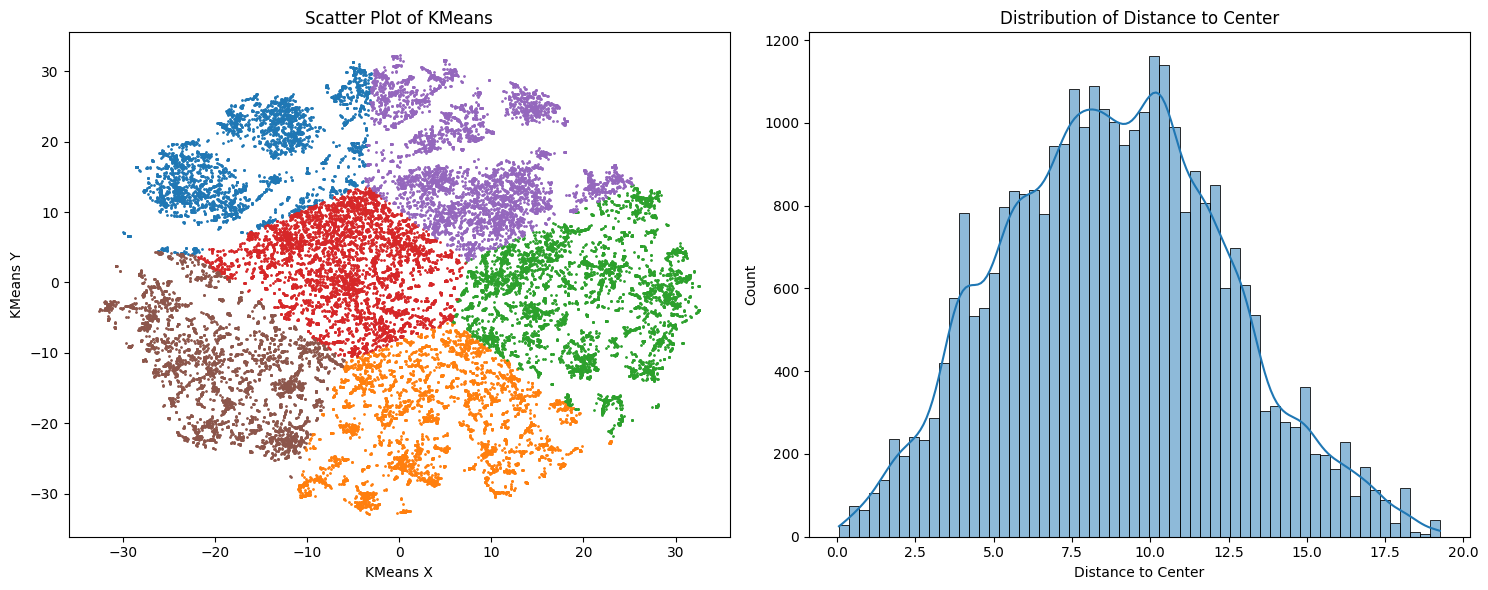

In [ ]:
# 데이터 및 필요한 컬럼 설정
remaining_df_4['kmeans_x'] = tsne_result[:, 0]
remaining_df_4['kmeans_y'] = tsne_result[:, 1]

# 그림 설정
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns

# 첫 번째 그래프 (scatter plot)
for i in range(0, 6):
    _df = remaining_df_4[remaining_df_4['label_5'] == i]
    axes[0].scatter(x=_df.kmeans_x, y=_df.kmeans_y, s=1)
axes[0].set_title('Scatter Plot of KMeans')
axes[0].set_xlabel('KMeans X')
axes[0].set_ylabel('KMeans Y')

# 두 번째 그래프 (histogram)
sns.histplot(remaining_df_4['distance_to_center'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Distance to Center')
axes[1].set_xlabel('Distance to Center')
axes[1].set_ylabel('Count')

plt.tight_layout() # 서브플롯 간의 간격 조정
plt.show()

In [ ]:
pd.set_option('display.max_colwidth', None)
def print_sample_tsne(df):
  for cluster in range(0,6):
    print('********** cluster {} **********'.format(cluster))
    _sample = df[df['label_5'] == cluster]['text'].head(20)
    idxs = list(_sample.index)
    for idx in idxs:
      print(df['text'][idx])
    print("\n")
print_sample_tsne(filtered_df_5)

********** cluster 0 **********
GAME DAY PREVIEW Game time: 6:00 PM : CHARLOTTE, North Carolina (Ticker) -- The Detroit Shock face a critical road test Saturday when they take on the Charlotte Sting at Charlotte Coliseum.
Tavarez Breaks Hand After Leaving Game 4 (AP) : AP - St. Louis righty Julian Tavarez broke his left hand during a dugout tantrum in Game 4 of the NL championship series, and it was uncertain Monday when the reliever would pitch again.
Different routes, same result as teams gird for title game : It no longer matters that Montana #39;s drive to the NCAA Division I-AA football championship game has featured six straight homefield victories - all
Georgia at Auburn : The debate stoked by Southern football fans all summer long seems fairly hilarious now. The question -- you remember it -- was, which will be the better conference, the SEC or the new ACC?
NHL is on thin ice : There was plenty of rejection to go around yesterday. First, the National Hockey League owners -- via

In [ ]:
mapping5 = {
    0 : 'world',
    1 : 'sports',
    2 : 'business',
    3 : 'sports',
    4 : 'tech',
    5 : 'entertainment'
}

filtered_df_5['label_5'] = filtered_df_5['label_5'].apply(lambda x: mapping5[x])

<ipython-input-376-328a561b509d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_5['label_5'] = filtered_df_5['label_5'].apply(lambda x: mapping5[x])


In [ ]:
filtered_df_5.head()

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2,label_3,label_4,label_5,label_6,label_7
26,NEWS_00026,"Doping case was flawed, report finds","MONTREAL A series of errors and misunderstandings led to the botched drug test that resulted in Tyler Hamilton, the American cyclist, retaining his gold medal from the Athens Olympics, the World Anti-Doping Agency has said in a report.","Doping case was flawed, report finds : MONTREAL A series of errors and misunderstandings led to the botched drug test that resulted in Tyler Hamilton, the American cyclist, retaining his gold medal from the Athens Olympics, the World Anti-Doping Agency has said in a report.","doping case was flawed, report finds : montreal a series of errors and misunderstandings led to the botched drug test that resulted in tyler hamilton, the american cyclist, retaining his gold medal from the athens olympics, the world anti-doping agency has said in a report.",4,2.842107,5.655376,15.913673,5.0,politics,NaN,NaN,NaN,sports,sports,NaN
50,NEWS_00050,UN Predicts Boom In Robot Labor,"The use of robots around the home to mow lawns, vacuum floors and manage other chores is set to surge sevenfold by 2007 as more consumers snap up smart machines, the United Nations said.","UN Predicts Boom In Robot Labor : The use of robots around the home to mow lawns, vacuum floors and manage other chores is set to surge sevenfold by 2007 as more consumers snap up smart machines, the United Nations said.","un predicts boom in robot labor : the use of robots around the home to mow lawns, vacuum floors and manage other chores is set to surge sevenfold by as more consumers snap up smart machines, the united nations said.",0,4.410042,-13.601522,-1.554148,5.0,sports,NaN,NaN,NaN,entertainment,NaN,NaN
76,NEWS_00076,WATCH,//www.huffingtonpost.com/entry/perrish-cox-flop-49ers-saints_n_6129774.html short_description,WATCH : //www.huffingtonpost.com/entry/perrish-cox-flop-49ers-saints_n_6129774.html short_description,watch : perrish-cox-flop-ers-saints_n_.,1,4.489092,-8.622788,19.673941,NaN,NaN,NaN,NaN,NaN,sports,NaN,NaN
99,NEWS_00099,"Rigel, Merck Form Development Partnership","NEW YORK (Reuters) - Biotechnology company Rigel Pharmaceuticals Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=RIGL.O target=/stocks/quickinfo/fullquote""&gt;RIGL.O&lt;/A&gt; has entered into a collaboration pact with drugmaker Merck Co. Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=MRK.N target=/stocks/quickinfo/fullquote""&gt;MRK.N&lt;/A&gt; to find treatments for cancer and potentially other diseases, Rigel said on Monday.","Rigel, Merck Form Development Partnership : NEW YORK (Reuters) - Biotechnology company Rigel Pharmaceuticals Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=RIGL.O target=/stocks/quickinfo/fullquote""&gt;RIGL.O&lt;/A&gt; has entered into a collaboration pact with drugmaker Merck Co. Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=MRK.N target=/stocks/quickinfo/fullquote""&gt;MRK.N&lt;/A&gt; to find treatments for cancer and potentially other diseases, Rigel said on Monday.","rigel, merck form development partnership : new york (reuters) - biotechnology company rigel pharmaceuticals inc. &lt;a href=""http://www.investor.reuters.com/fullquote.aspx?ticker=rigl.o target=/stocks/quickinfo/fullquote""&gt;rigl.o&lt;/a&gt; has entered into a collaboration pact with drugmaker merck co. inc. &lt;a href=""http://www.investor.reuters.com/fullquote.aspx?ticker=mrk.n target=/stocks/quickinfo/fullquote""&gt;mrk.n&lt;/a&gt; to find treatments for cancer and potentially other diseases, rigel said on monday.",5,4.233129,-1.326915,-10.445642,5.0,business,NaN,NaN,NaN,tech,NaN,NaN
108,NEWS_00108,Flint-Like Lead Hazards May Be Lurking In Private Water Wells authors,Across the country millions of Americans served by private wells drink bathe and cook with water containing p

In [ ]:
filtered_df_5['distance_to_center'].describe()

count    4036.000000
mean        3.255958
std         1.184190
min         0.047464
25%         2.376371
50%         3.389196
75%         4.329247
max         4.999847
Name: distance_to_center, dtype: float64

In [ ]:
# 원래 df에 'label_5'열 추가
condition_indices1 = filtered_df_5['label_5'].index
df.loc[condition_indices1, 'label_5'] = filtered_df_5['label_5']

# filtered_df_3의 카테고리(문자열)을 df에도 적용한다.
df.loc[filtered_df_5.index, 'label'] = filtered_df_5['label_5']

# 원래 df에 'label_5'가 결정되면 'define' 열에 '3'입력
condition_indices2 = filtered_df_5[filtered_df_5['distance_to_center'] < 5].index
df.loc[condition_indices2, 'define'] = 5

In [ ]:
df[40:41]

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2,label_3,label_4,label_5,label_6,label_7
40,NEWS_00040,"Out for V-I-C-T-O-R-Y, but Missing Tiles",Missing a key piece to your favorite board game? The Web's abundance of board game sites might help.,"Out for V-I-C-T-O-R-Y, but Missing Tiles : Missing a key piece to your favorite board game? The Web's abundance of board game sites might help.","out for v-i-c-t-o-r-y, but missing tiles : missing a key piece to your favorite board game? the web's abundance of board game sites might help.",1,13.536786,-23.997971,3.518291,4.0,tech,NaN,NaN,tech,tech,NaN,NaN


# 6차 군집화

In [ ]:
# 다시 군집화해야하는 데이터 모음
remaining_df_5 = df[~df['define'].isin([1, 2, 3, 4, 5])]



0.4424166666666667

In [ ]:
# 텍스트 feature 추출
sentence_embeddings = model.encode(remaining_df_5['processed_text'].tolist())
# 추출한 feature를 데이터프레임에 저장
df_embeddings = pd.DataFrame(sentence_embeddings)
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 25, n_iter = 400) # ver15 전처리함수 변경
# tsne 객체의 fit_transform 메소드를 사용 -> df_embeddings 데이터프레임에 있는 고차원 데이터를 2차원으로 변환
tsne_result = tsne.fit_transform(df_embeddings)
from sklearn.cluster import MiniBatchKMeans
minibatch_kmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', batch_size=200, random_state=SEED)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(tsne_result)
remaining_df_5.loc[:, 'label_6'] = minibatch_kmeans_labels

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 26545 samples in 0.007s...
[t-SNE] Computed neighbors for 26545 samples in 9.909s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26545
[t-SNE] Computed conditional probabilities for sample 2000 / 26545
[t-SNE] Computed conditional probabilities for sample 3000 / 26545
[t-SNE] Computed conditional probabilities for sample 4000 / 26545
[t-SNE] Computed conditional probabilities for sample 5000 / 26545
[t-SNE] Computed conditional probabilities for sample 6000 / 26545
[t-SNE] Computed conditional probabilities for sample 7000 / 26545
[t-SNE] Computed conditional probabilities for sample 8000 / 26545
[t-SNE] Computed conditional probabilities for sample 9000 / 26545
[t-SNE] Computed conditional probabilities for sample 10000 / 26545
[t-SNE] Computed conditional probabilities for sample 11000 / 26545
[t-SNE] Computed conditional probabilities for sample 12000 / 26545
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-379-87b1586f5b19>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_5.loc[:, 'label_6'] = minibatch_kmeans_labels


In [ ]:
# 각 데이터 포인트에 대해 가장 가까운 클러스터 중심까지의 거리를 계산합니다.
distances = np.min(minibatch_kmeans.transform(tsne_result), axis=1)

# distances 변수에는 각 데이터 포인트가 할당된 클러스터 중심까지의 거리가 저장되어 있습니다.
remaining_df_5.loc[:, 'distance_to_center'] = distances

<ipython-input-380-9f9937573690>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_5.loc[:, 'distance_to_center'] = distances


In [ ]:
remaining_df_5['distance_to_center'].describe()

count    15845.000000
mean         8.559944
std          3.532937
min          0.058021
25%          6.102105
50%          8.787635
75%         11.021766
max         17.595125
Name: distance_to_center, dtype: float64

In [ ]:
filtered_df_6 = remaining_df_5[remaining_df_5['distance_to_center'] < 5]
condition_indices = remaining_df_5[remaining_df_5['distance_to_center'] < 5].index
df.loc[df.index.isin(condition_indices), 'define'] = 6
# 전체 데이터 중에서 군집화가 완료된 데이터의 비율을 계산합니다.
len(filtered_df_6) / len(remaining_df_5)

0.16097193445093239

In [ ]:
pd.set_option('display.max_colwidth', None)
def print_sample_tsne(df):
  for cluster in range(0,6):
    print('********** cluster {} **********'.format(cluster))
    _sample = df[df['label_6'] == cluster]['text'][20:30]
    idxs = list(_sample.index)
    for idx in idxs:
      print(df['text'][idx])
    print("\n")
print_sample_tsne(filtered_df_6)

********** cluster 0 **********
Iraq group to free 3 Indians, 4 others of Kuwait firm - TV (Reuters) : Reuters - Iraqi kidnappers of seven employees of a Kuwaiti company said in a video statement on Thursday they would release the captives once their employer halted operations in Iraq, Al Arabiya television reported.
TV station put on US terror list : The United States bans Hezbollah's al-Manar television station, saying it incites violence in the Middle East.
Al Jazeera Reports Journalist Executed : The Iraqi kidnappers of Italian journalist Enzo Baldoni killed him because Italy refused to heed their earlier deadline to withdraw troops from Iraq, says Al Jazeera television.
Arab Commentators Examine Terrorism, Islam Link : The violent hostage-taking at a school in Russia last week blamed on Chechen terrorists has sparked condemnation from the Arab media in the Middle East.
Australia Firm on Troops After Iraq Hostage Report (Reuters) : Reuters - Australian Prime Minister John Howard\re

In [ ]:
mapping6 = {
    0 : 'entertainment',
    1 : 'world',
    2 : 'tech',
    3 : 'sports',
    4 : 'business',
    5 : 'politics'
}


filtered_df_6['label_6'] = filtered_df_6['label_6'].apply(lambda x: mapping6[x])

<ipython-input-383-db6010544c22>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_6['label_6'] = filtered_df_6['label_6'].apply(lambda x: mapping6[x])


In [ ]:
filtered_df_6.head()

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2,label_3,label_4,label_5,label_6,label_7
25,NEWS_00025,Be on TOP,//www.huffingtonpost.com/entry/be-on-top-amazon-best-sel_b_12508618.html short_description,Be on TOP : //www.huffingtonpost.com/entry/be-on-top-amazon-best-sel_b_12508618.html short_description,be on top : be-on-top-amazon-best-sel_b_.,1,2.994144,-12.375463,1.268041,NaN,NaN,NaN,NaN,NaN,NaN,politics,NaN
78,NEWS_00078,Burundi Agrees to Move Tutsi Refugees to Safety,"Following last week #39;s massacre of at least 160 Congolese Tutsis at a refugee camp near Burundi #39;s border with the Democratic Republic of Congo, the Burundian government is speeding up efforts to help the United Nations set up more secure camps in the","Burundi Agrees to Move Tutsi Refugees to Safety : Following last week #39;s massacre of at least 160 Congolese Tutsis at a refugee camp near Burundi #39;s border with the Democratic Republic of Congo, the Burundian government is speeding up efforts to help the United Nations set up more secure camps in the","burundi agrees to move tutsi refugees to safety : following last week ;s massacre of at least congolese tutsis at a refugee camp near burundi ;s border with the democratic republic of congo, the burundian government is speeding up efforts to help the united nations set up more secure camps in the",2,2.633071,25.758686,-11.970181,6.0,world,NaN,NaN,NaN,NaN,world,NaN
89,NEWS_00089,Presidential Debates and Middle-Class Economics authors,While a lack of middle-class income growth can create headwinds for any economy in the short term the longer-term risks of political instability and civil unrest can become much greater.,Presidential Debates and Middle-Class Economics authors : While a lack of middle-class income growth can create headwinds for any economy in the short term the longer-term risks of political instability and civil unrest can become much greater.,presidential debates and middle-class economics authors : while a lack of middle-class income growth can create headwinds for any economy in the short term the longer-term risks of political instability and civil unrest can become much greater.,5,3.571160,3.019636,-7.654747,6.0,NaN,NaN,NaN,NaN,NaN,politics,NaN
102,NEWS_00102,A Lot Of Managers Want to Raise The Minimum Wage Too authors,A new survey finds that the people who hire minimum-wage workers support giving them a raise.,A Lot Of Managers Want to Raise The Minimum Wage Too authors : A new survey finds that the people who hire minimum-wage workers support giving them a raise.,a lot of managers want to raise the minimum wage too authors : a new survey finds that the people who hire minimum-wage workers support giving them a raise.,5,0.746956,2.660934,-9.008695,6.0,NaN,NaN,NaN,NaN,NaN,politics,NaN
113,NEWS_00113,Coal Companies Paid Lobbyists Millions Before Going Bankrupt authors,And then they cut employee benefits.,Coal Companies Paid Lobbyists Millions Before Going Bankrupt authors : And then they cut employee benefits.,coal companies paid lobbyists millions before going bankrupt authors : and then they cut employee benefits.,3,3.578953,4.730982,-9.299649,6.0,NaN,NaN,NaN,NaN,NaN,politics,NaN


---

In [ ]:
# 원래 df에 'label_6'열 추가
condition_indices1 = filtered_df_6['label_6'].index
df.loc[condition_indices1, 'label_6'] = filtered_df_6['label_6']

# filtered_df_3의 카테고리(문자열)을 df에도 적용한다.
df.loc[filtered_df_6.index, 'label'] = filtered_df_6['label_6']

# 원래 df에 'label_6'가 결정되면 'define' 열에 '6'입력
condition_indices2 = filtered_df_6[filtered_df_6['distance_to_center'] < 5].index
df.loc[condition_indices2, 'define'] = 6

In [ ]:
df[113:114]

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2,label_3,label_4,label_5,label_6,label_7,label_8
113,NEWS_00113,Coal Companies Paid Lobbyists Millions Before Going Bankrupt authors,And then they cut employee benefits.,Coal Companies Paid Lobbyists Millions Before Going Bankrupt authors : And then they cut employee benefits.,coal companies paid lobbyists millions before going bankrupt authors : and then they cut employee benefits.,3,10.727244,4.730982,-9.299649,6.0,politics,NaN,NaN,NaN,NaN,politics,NaN,NaN


# 7차 군집화

In [ ]:
# 다시 군집화해야하는 데이터 모음
remaining_df_6 = df[~df['define'].isin([1, 2, 3, 4, 5, 6])]

# 다시 군집화 해야하는 데이터의 비율
len(remaining_df_6) / len(df)

0.3712

In [ ]:
# 텍스트 feature 추출
sentence_embeddings = model.encode(remaining_df_6['processed_text'].tolist())
# 추출한 feature를 데이터프레임에 저장
df_embeddings = pd.DataFrame(sentence_embeddings)
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 25, n_iter = 400) # ver15 전처리함수 변경
# tsne 객체의 fit_transform 메소드를 사용 -> df_embeddings 데이터프레임에 있는 고차원 데이터를 2차원으로 변환
tsne_result = tsne.fit_transform(df_embeddings)
from sklearn.cluster import MiniBatchKMeans
minibatch_kmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', batch_size=200, random_state=SEED)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(tsne_result)
remaining_df_6.loc[:, 'label_7'] = minibatch_kmeans_labels

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 22272 samples in 0.006s...
[t-SNE] Computed neighbors for 22272 samples in 6.340s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22272
[t-SNE] Computed conditional probabilities for sample 2000 / 22272
[t-SNE] Computed conditional probabilities for sample 3000 / 22272
[t-SNE] Computed conditional probabilities for sample 4000 / 22272
[t-SNE] Computed conditional probabilities for sample 5000 / 22272
[t-SNE] Computed conditional probabilities for sample 6000 / 22272
[t-SNE] Computed conditional probabilities for sample 7000 / 22272
[t-SNE] Computed conditional probabilities for sample 8000 / 22272
[t-SNE] Computed conditional probabilities for sample 9000 / 22272
[t-SNE] Computed conditional probabilities for sample 10000 / 22272
[t-SNE] Computed conditional probabilities for sample 11000 / 22272
[t-SNE] Computed conditional probabilities for sample 12000 / 22272
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-386-0f6f30baf102>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_6.loc[:, 'label_7'] = minibatch_kmeans_labels


In [ ]:
# 각 데이터 포인트에 대해 가장 가까운 클러스터 중심까지의 거리를 계산합니다.
distances = np.min(minibatch_kmeans.transform(tsne_result), axis=1)

# distances 변수에는 각 데이터 포인트가 할당된 클러스터 중심까지의 거리가 저장되어 있습니다.
remaining_df_6.loc[:, 'distance_to_center'] = distances

<ipython-input-387-559878cb19bc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_6.loc[:, 'distance_to_center'] = distances


In [ ]:
remaining_df_6['distance_to_center'].describe()

count    10914.000000
mean         8.665503
std          3.450377
min          0.076581
25%          6.249797
50%          8.850969
75%         11.334229
max         17.234520
Name: distance_to_center, dtype: float64

<ipython-input-388-148dcb16d688>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_6['kmeans_x'] = tsne_result[:, 0]
<ipython-input-388-148dcb16d688>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_6['kmeans_y'] = tsne_result[:, 1]


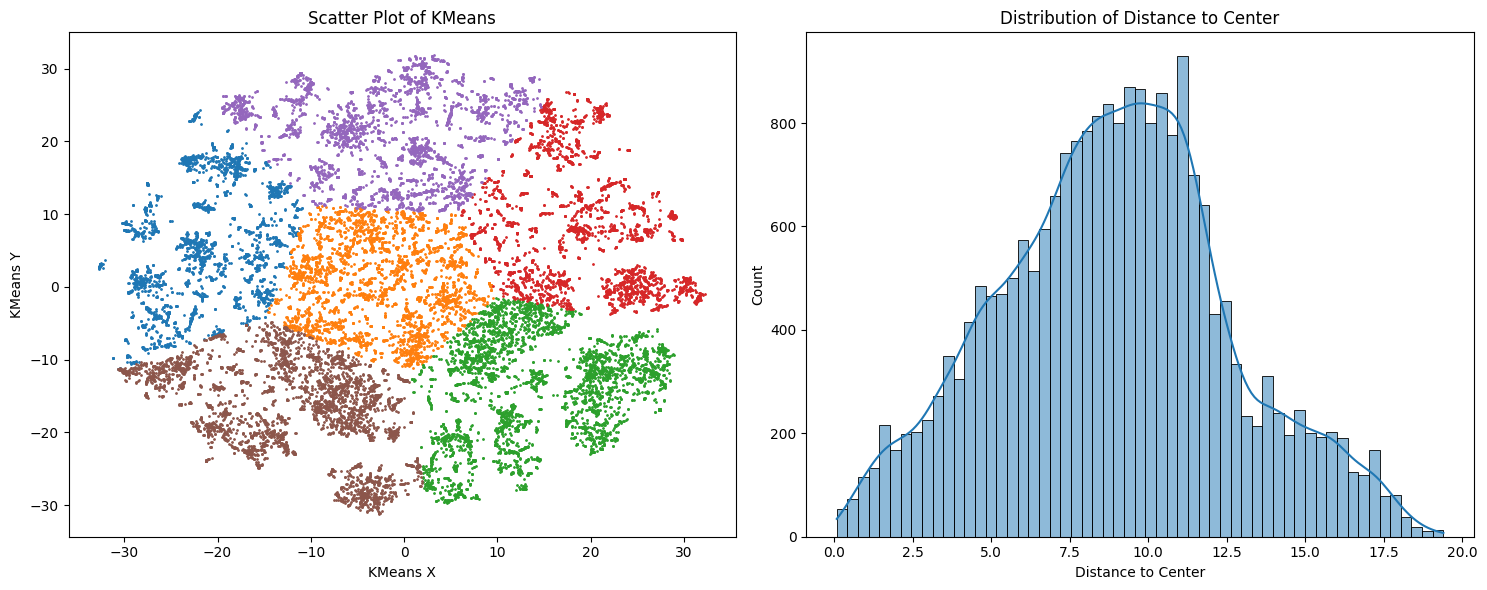

In [ ]:
# 데이터 및 필요한 컬럼 설정
remaining_df_6['kmeans_x'] = tsne_result[:, 0]
remaining_df_6['kmeans_y'] = tsne_result[:, 1]

# 그림 설정
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns

# 첫 번째 그래프 (scatter plot)
for i in range(0, 6):
    _df = remaining_df_6[remaining_df_6['label_7'] == i]
    axes[0].scatter(x=_df.kmeans_x, y=_df.kmeans_y, s=1)
axes[0].set_title('Scatter Plot of KMeans')
axes[0].set_xlabel('KMeans X')
axes[0].set_ylabel('KMeans Y')

# 두 번째 그래프 (histogram)
sns.histplot(remaining_df_6['distance_to_center'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Distance to Center')
axes[1].set_xlabel('Distance to Center')
axes[1].set_ylabel('Count')

plt.tight_layout() # 서브플롯 간의 간격 조정
plt.show()

In [ ]:
filtered_df_7 = remaining_df_6[remaining_df_6['distance_to_center'] < 7.5]
condition_indices = remaining_df_6[remaining_df_6['distance_to_center'] < 7.5].index
df.loc[df.index.isin(condition_indices), 'define'] = 7
# 전체 데이터 중에서 군집화가 완료된 데이터의 비율을 계산합니다.
len(filtered_df_7) / len(remaining_df_6)

0.3429867097701149

In [ ]:
pd.set_option('display.max_colwidth', None)
def print_sample_tsne(df):
  for cluster in range(0,6):
    print('********** cluster {} **********'.format(cluster))
    _sample = df[df['label_7'] == cluster]['text'][25:40]
    idxs = list(_sample.index)
    for idx in idxs:
      print(df['text'][idx])
    print("\n")
print_sample_tsne(filtered_df_7)

********** cluster 0 **********
Senate stamp on Pervez post : Islamabad, Nov. 1. - Amid strong protests from opposition lawmakers, Pakistans Parliament today approved a Bill allowing President Pervez Musharraf to continue as Pakistans army chief, disregarding
Charley May Not Spike Insurance Premiums : MIAMI - Hurricane Charley probably will not cause Floridians' insurance premiums to skyrocket like 1992's Andrew, and fewer insurers should go bankrupt from paying out damages expected to reach the billions of dollars, state and industry officials said Saturday.    They say previous premium increases and overhauls made because of Andrew, the most expensive natural disaster in U.S...
Hurricane Charley hits Outback : NEW YORK (Reuters) - Outback Steakhouse Inc. said Tuesday it lost about 130 operating days and up to \$2 million in revenue because it had to close some restaurants in the South due to Hurricane Charley.
Florida braces itself for Hurricane Jeanne : For Florida, the hurricane se

In [ ]:
mapping7 = {
    0 : 'world', # 애매하다..
    1 : 'sports',
    2 : 'tech',
    3 : 'entertainment',
    4 : 'business', # 애매하다..
    5 : 'politics'
}



filtered_df_7['label_7'] = filtered_df_7['label_7'].apply(lambda x: mapping7[x])

<ipython-input-391-219a48191e56>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_7['label_7'] = filtered_df_7['label_7'].apply(lambda x: mapping7[x])


In [ ]:
# 원래 df에 'label_7'열 추가
condition_indices1 = filtered_df_7['label_7'].index
df.loc[condition_indices1, 'label_7'] = filtered_df_7['label_7']

# filtered_df_3의 카테고리(문자열)을 df에도 적용한다.
df.loc[filtered_df_7.index, 'label'] = filtered_df_7['label_7']

# 원래 df에 'label_7'가 결정되면 'define' 열에 '7'입력
condition_indices2 = filtered_df_7[filtered_df_7['distance_to_center'] < 5].index
df.loc[condition_indices2, 'define'] = 7

# 8차 군집화

In [ ]:
# 다시 군집화해야하는 데이터 모음
remaining_df_7 = df[~df['define'].isin([1, 2, 3, 4, 5, 6, 7])]

# 다시 군집화 해야하는 데이터의 비율
len(remaining_df_7) / len(df)

0.24388333333333334

In [ ]:
#

print("첫번째 군집 : ",len(filtered_df_1) / len(df))
print("첫번째 군집 후 남은 데이터 비율: " , len(remaining_df_1) / len(df))
print("---")
print("두번째 군집 : ",len(filtered_df_2) / len(df))
print("두번째 군집 후 남은 데이터 비율: " , len(remaining_df_2) / len(df))
print("---")
print("첫번째 군집 : ",len(filtered_df_3) / len(df))
print("첫번째 군집 후 남은 데이터 비율: " , len(remaining_df_3) / len(df))
print("---")
print("첫번째 군집 : ",len(filtered_df_4) / len(df))
print("첫번째 군집 후 남은 데이터 비율: " , len(remaining_df_4) / len(df))
print("---")
print("첫번째 군집 : ",len(filtered_df_5) / len(df))
print("첫번째 군집 후 남은 데이터 비율: " , len(remaining_df_5) / len(df))
print("---")
print("첫번째 군집 : ",len(filtered_df_6) / len(df))
print("첫번째 군집 후 남은 데이터 비율: " , len(remaining_df_6) / len(df))
print("---")
print("첫번째 군집 : ",len(filtered_df_7) / len(df))
print("첫번째 군집 후 남은 데이터 비율: " , len(remaining_df_7) / len(df))
print("---")

첫번째 군집 :  0.1649
첫번째 군집 후 남은 데이터 비율:  0.8351
---
두번째 군집 :  0.13201666666666667
두번째 군집 후 남은 데이터 비율:  0.7030833333333333
---
첫번째 군집 :  0.10038333333333334
첫번째 군집 후 남은 데이터 비율:  0.6027
---
첫번째 군집 :  0.08138333333333334
첫번째 군집 후 남은 데이터 비율:  0.5213166666666667
---
첫번째 군집 :  0.0789
첫번째 군집 후 남은 데이터 비율:  0.4424166666666667
---
첫번째 군집 :  0.07121666666666666
첫번째 군집 후 남은 데이터 비율:  0.3712
---
첫번째 군집 :  0.12731666666666666
첫번째 군집 후 남은 데이터 비율:  0.24388333333333334
---


# 8차 군집화 (마지막)

In [ ]:
# remaining_df_7

# 텍스트 feature 추출
sentence_embeddings = model.encode(remaining_df_7['processed_text'].tolist())

# 추출한 feature를 데이터프레임에 저장
df_embeddings = pd.DataFrame(sentence_embeddings)

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 25, n_iter = 400) # ver15 전처리함수 변경
# tsne 객체의 fit_transform 메소드를 사용 -> df_embeddings 데이터프레임에 있는 고차원 데이터를 2차원으로 변환
tsne_result = tsne.fit_transform(df_embeddings)

from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', batch_size=200, random_state=SEED)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(tsne_result)
remaining_df_7.loc[:, 'label_8'] = minibatch_kmeans_labels

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 14633 samples in 0.004s...
[t-SNE] Computed neighbors for 14633 samples in 2.825s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14633
[t-SNE] Computed conditional probabilities for sample 2000 / 14633
[t-SNE] Computed conditional probabilities for sample 3000 / 14633
[t-SNE] Computed conditional probabilities for sample 4000 / 14633
[t-SNE] Computed conditional probabilities for sample 5000 / 14633
[t-SNE] Computed conditional probabilities for sample 6000 / 14633
[t-SNE] Computed conditional probabilities for sample 7000 / 14633
[t-SNE] Computed conditional probabilities for sample 8000 / 14633
[t-SNE] Computed conditional probabilities for sample 9000 / 14633
[t-SNE] Computed conditional probabilities for sample 10000 / 14633
[t-SNE] Computed conditional probabilities for sample 11000 / 14633
[t-SNE] Computed conditional probabilities for sample 12000 / 14633
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-395-e2485284eb98>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_7.loc[:, 'label_8'] = minibatch_kmeans_labels


In [ ]:
# 각 데이터 포인트에 대해 가장 가까운 클러스터 중심까지의 거리를 계산합니다.
distances = np.min(minibatch_kmeans.transform(tsne_result), axis=1)

# distances 변수에는 각 데이터 포인트가 할당된 클러스터 중심까지의 거리가 저장되어 있습니다.
remaining_df_7.loc[:, 'distance_to_center'] = distances

<ipython-input-396-61e6db8d0b5f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_7.loc[:, 'distance_to_center'] = distances


<ipython-input-397-cd9907f866c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_7['kmeans_x'] = tsne_result[:, 0]
<ipython-input-397-cd9907f866c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_7['kmeans_y'] = tsne_result[:, 1]


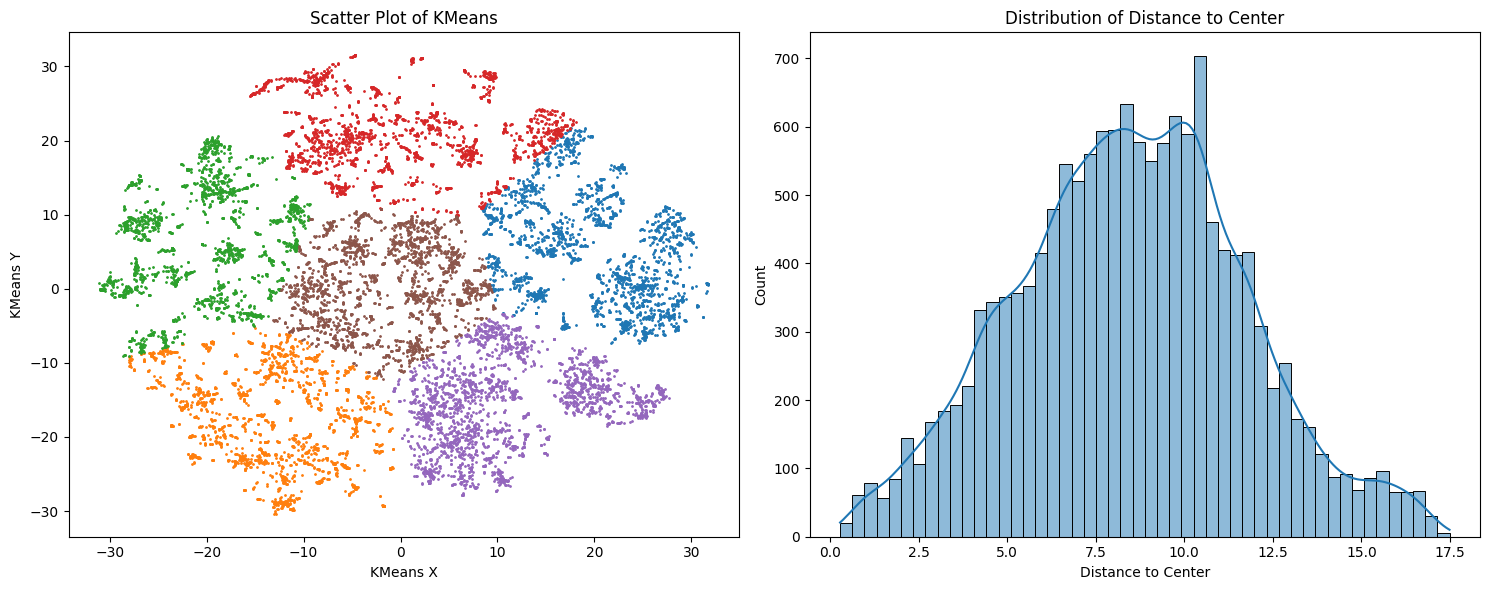

In [ ]:
# 데이터 및 필요한 컬럼 설정
remaining_df_7['kmeans_x'] = tsne_result[:, 0]
remaining_df_7['kmeans_y'] = tsne_result[:, 1]

# 그림 설정
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns

# 첫 번째 그래프 (scatter plot)
for i in range(0, 6):
    _df = remaining_df_7[remaining_df_7['label_8'] == i]
    axes[0].scatter(x=_df.kmeans_x, y=_df.kmeans_y, s=1)
axes[0].set_title('Scatter Plot of KMeans')
axes[0].set_xlabel('KMeans X')
axes[0].set_ylabel('KMeans Y')

# 두 번째 그래프 (histogram)
sns.histplot(remaining_df_7['distance_to_center'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Distance to Center')
axes[1].set_xlabel('Distance to Center')
axes[1].set_ylabel('Count')

plt.tight_layout() # 서브플롯 간의 간격 조정
plt.show()

In [ ]:
remaining_df_7['distance_to_center'].describe()

count    6238.000000
mean        7.968470
std         3.034853
min         0.204041
25%         5.889190
50%         7.879447
75%         9.920604
max        18.976591
Name: distance_to_center, dtype: float64

In [ ]:
remaining_df_7.head()

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2,label_3,label_4,label_5,label_6,label_7,label_8
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors,Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors : Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,only lovers left alive's tilda swinton talks about almost quitting acting and yasmine hamdan performs 'hal' live in nyc (huffpo exclusive videos) authors : yasmine hamdan performs 'hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,1,5.381731,-4.799878,-17.659903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
22,NEWS_00022,"College Basketball: Georgia Tech, UConn Win",ATLANTA (Sports Network) - BJ Elder poured in a game-high 27 points to lead fourth-ranked Georgia Tech to a convincing 99-68 win over Michigan in the ACC-Big Ten Challenge at Alexander Memorial Coliseum.,"College Basketball: Georgia Tech, UConn Win : ATLANTA (Sports Network) - BJ Elder poured in a game-high 27 points to lead fourth-ranked Georgia Tech to a convincing 99-68 win over Michigan in the ACC-Big Ten Challenge at Alexander Memorial Coliseum.","college basketball: georgia tech, uconn win : atlanta (sports network) - bj elder poured in a game-high points to lead fourth-ranked georgia tech to a convincing - win over michigan in the acc-big ten challenge at alexander memorial coliseum.",1,4.248112,19.652603,0.843532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
24,NEWS_00024,Kentucky Fan Gets National Champs Tattoo. Let's Hope It Happens For Him. authors,That's some real confidence bro.,Kentucky Fan Gets National Champs Tattoo. Let's Hope It Happens For Him. authors : That's some real confidence bro.,kentucky fan gets national champs tattoo. let's hope it happens for him. authors : that's some real confidence bro.,4,4.704863,15.279143,0.893160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
29,NEWS_00029,Israel Kills 3 Palestinians in Big Gaza Incursion (Reuters),"Reuters - Israeli forces killed three\Palestinians, including two teenagers, on Wednesday after\storming into the northern Gaza Strip for the third time in as\many months to quell Palestinian rocket fire into Israel.","Israel Kills 3 Palestinians in Big Gaza Incursion (Reuters) : Reuters - Israeli forces killed three\Palestinians, including two teenagers, on Wednesday after\storming into the northern Gaza Strip for the third time in as\many months to quell Palestinian rocket fire into Israel.","israel kills palestinians in big gaza incursion (reuters) : reuters - israeli forces killed three palestinians, including two teenagers, on wednesday after storming into the northern gaza strip for the third time in as many months to quell palestinian rocket fire into israel.",2,6.937297,3.217307,26.213509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
33,NEWS_00033,Memo To EPA Chief Pruitt,//www.huffingtonpost.com/entry/memo-to-epa-chief-pruitt-lets-end-subsidies-for-fossil_us_59ee9567e4b0b8a51417bcc6 short_description,Memo To EPA Chief Pruitt : //www.huffingtonpost.com/entry/memo-to-epa-chief-pruitt-lets-end-subsidies-for-fossil_us_59ee9567e4b0b8a51417bcc6 short_description,memo to epa chief pruitt : memo-to-epa-chief-pruitt-lets-end-subsidies-for-fossil_us_eeebbabcc,5,11.241887,-0.694164,-0.630005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [ ]:
pd.set_option('display.max_colwidth', None)
def print_sample_tsne(df):
  for cluster in range(0,6):
    print('********** cluster {} **********'.format(cluster))
    _sample = df[df['label_8'] == cluster]['text'].head(20)
    idxs = list(_sample.index)
    for idx in idxs:
      print(df['text'][idx])
    print("\n")
print_sample_tsne(remaining_df_7)

********** cluster 0 **********
Longhorns Rip Cowboys : Cedric Benson scores five touchdowns on Saturday night, highlighting a 49-point rally that sends No. 6 Texas to a stunning 56-35 win over No. 19 Oklahoma State.
IBM to use AMD's dual-core Opteron : Upgrade to high-performance server will include AMD's dual-core chip.
Lindsey Graham : //www.huffingtonpost.com/entry/lindsey-graham-syria_n_5665831.html short_description
Finalists Named for O'Brien Award : FORT WORTH, Texas (Sports Network) - Oklahoma quarterback  Jason White was one of three finalists announced Tuesday for  the Davey O'Brien Award as the nation's top quarterback.
Reince Priebus : //www.huffingtonpost.com/entry/reince-priebus-trump-wont-meddle-social-security-and-medicare_us_58739d63e4b099cdb0fe4047 short_description
Another Product Delay at Intel : Intel originally announced it had developed chip technology for high-definition big-screen televisions at the annual Consumer Electronics Show in January. It originally ex

In [ ]:
mapping8 = {
    0 : 'business',
    1 : 'tech',
    2 : 'world',
    3 : 'entertainment',
    4 : 'sports',
    5 : 'politics'
}


In [ ]:
remaining_df_7['label_8'] = remaining_df_7['label_8'].apply(lambda x: mapping8[x])

<ipython-input-399-54aaf294e760>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df_7['label_8'] = remaining_df_7['label_8'].apply(lambda x: mapping8[x])


In [ ]:
# filtered_df_2의 카테고리 숫자 -> 문자열
df.loc[remaining_df_7.index, 'label'] = remaining_df_7['label_8']

# 원래 df에 'label_8'열 추가
condition_indices3 = remaining_df_7['label_8'].index
df.loc[condition_indices3, 'label_8'] = remaining_df_7['label_8']

# 원래 df에 'label_8'가 결정되면 'define' 열에 '4'입력
condition_indices = remaining_df_7.index
df.loc[condition_indices, 'define'] = 8

In [ ]:
df.head(10)

,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2,label_3,label_4,label_5,label_6,label_7,label_8
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,spanish coach facing action in race row : madrid (afp) - spanish national team coach luis aragones faces a formal investigation after spain ;s football federation decided to open disciplinary proceedings over racist comments about thierry henry of france and arsenal.,business,4.635535,7.483770,26.020975,1.0,business,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","Bruce Lee statue for divided city : In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","bruce lee statue for divided city : in bosnia, where one man ;s hero is often another man ;s villain, some citizens have decided to honour one whom serbs, croats and muslims can all look up to - the kung fu great bruce lee.",2,6.165329,17.832108,-5.094157,4.0,world,NaN,NaN,world,NaN,NaN,NaN,NaN
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors,Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors : Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,only lovers left alive's tilda swinton talks about almost quitting acting and yasmine hamdan performs 'hal' live in nyc (huffpo exclusive videos) authors : yasmine hamdan performs 'hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,1,6.614978,-10.674074,8.462827,8.0,entertainment,NaN,NaN,NaN,NaN,NaN,NaN,entertainment
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,Macromedia contributes to eBay Stores : Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,macromedia contributes to ebay stores : macromedia has announced a special version of its contribute website editing application designed to simplify the creation and customisation of ebay stores.,0,7.514455,-23.450583,-13.033397,7.0,tech,NaN,NaN,NaN,NaN,NaN,tech,NaN
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,Qualcomm plans to phone it in on cellular repairs : Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,qualcomm plans to phone it in on cellular repairs : ove

In [ ]:
mapping_final = {
    'business' : 0,
    'entertainment':1,
    'politics':2,
    'sports':3,
    'tech':4,
    'world':5
}

In [ ]:
# df['label'] = df['label'].apply(lambda x: mapping_final[x])
df['label'] = df['label'].apply(lambda x: mapping_final[x])

In [ ]:
df[df['label'].isna()]


,id,title,contents,text,processed_text,label_1,distance_to_center,kmeans_x,kmeans_y,define,label,label_2,label_3,label_4,label_5,label_6,label_7,label_8


In [ ]:
df['label'].value_counts()

3    11358
1    10020
0     9858
4     9746
2     9695
5     9323
Name: label, dtype: int64

### Mapping

In [ ]:
tsne_mapping = {
    0: 4,
    1: 3,
    2: 2,
    3: 5,
    4: 0,
    5: 1,
}

In [ ]:
df['tsne_mapping'] = df['tsne_k_means++'].apply(lambda x: tsne_mapping[x])

## Submission

In [ ]:
sample = pd.read_csv('sample_submission.csv')

In [ ]:
sample['category'] = df['label'].values
sample['category'].head()

0    0
1    0
2    4
3    4
4    4
Name: category, dtype: int64

In [ ]:
sample.to_csv('baseline_submit.csv', index=False)